<div class="alert alert-warning"> <b>Team Lead comment:</b>Hey, Mike! Thanks for submitting the final project! I see that you did a good job here and the research has a great structure! However, there are some moments that I'd love for you to clarify. You can find my comments below as you go) Will wait for the next version, cheers!
   
</div>

# Task: E-Commerce Product Range Analysis

****data descripion**** 

The dataset contains the transaction history of an online store that sells household goods.

The file `ecommerce_dataset_us.csv` contains the following columns:

`InvoiceNo` — order identifier

`StockCode` — item identifier

`Description` — item name

`Quantity`

`InvoiceDate` — order date

`UnitPrice` — price per item

`CustomerID`

***objective: finding out trands in product sells, prediction of product sells based on clusters***

## mandatory stages of analysis ##

### Step 1. Download the data and neaded libraries/tools

In [1]:
!python -m pip install --upgrade pip
!python -m pip install sidetable -U
!python -m pip install -U seaborn 
!python -m pip install pymystem3
!python -m pip install -U numpy
!python -m pip install fuzzywuzzy
!python -m pip install plotly
!python -m pip install gensim
!python -m pip install webcolors
#!python -m conda install -c anaconda nomkl y
!python -m pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose

In [2]:
# Loading all the libraries
import os
import pandas as pd
import numpy as np
from scipy import stats as st
import sklearn.cluster
from scipy.cluster import hierarchy
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import sidetable as stb
import plotly.express as px
import plotly.graph_objects as go
import math 

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from functools import reduce
from statsmodels.stats.proportion import proportions_ztest
import re

#nltk.download()
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer    
from pymystem3 import Mystem
from collections import Counter


%matplotlib inline

pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_colwidth = 300 

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/opt/conda/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
import sys
import warnings
if not sys.warnoptions:
        warnings.simplefilter("ignore");

In [4]:
# Load the data files into a DataFrame

try: 
    e_com = pd.read_csv('ecommerce_dataset_us.csv', sep="\t", parse_dates=['InvoiceDate'], error_bad_lines=False)         
    
except:
    e_com = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep="\t", parse_dates=['InvoiceDate'], error_bad_lines=False)
   

 
display(e_com.head(), len(e_com))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.550,17850.000
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.390,17850.000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.750,17850.000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.390,17850.000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.390,17850.000


541909

In [5]:
e_com.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000,541909.000,406829.000
mean,9.552,4.611,15287.691
std,218.081,96.760,1713.600
min,-80995.000,-11062.060,12346.000
25%,1.000,1.250,13953.000
50%,3.000,2.080,15152.000
75%,10.000,4.130,16791.000
max,80995.000,38970.000,18287.000


In [6]:
e_com["Quantity"] = abs(e_com["Quantity"])
e_com["UnitPrice"] = abs(e_com["UnitPrice"]) 

In [7]:
e_com.corr()

,Quantity,UnitPrice,CustomerID
Quantity,1.000,-0.002,-0.005
UnitPrice,-0.002,1.000,-0.005
CustomerID,-0.005,-0.005,1.000


### Step 2. Exploratory data analysis (EDA)

#### 2.1 Study missing values and deal with missing values (remove or replace)

In [8]:
e_com.stb.missing(style=True)

,missing,total,percent
CustomerID,"135,080","541,909",24.93%
Description,"1,454","541,909",0.27%
InvoiceNo,0,"541,909",0.00%
StockCode,0,"541,909",0.00%
Quantity,0,"541,909",0.00%
InvoiceDate,0,"541,909",0.00%
UnitPrice,0,"541,909",0.00%


In [9]:
e_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 28.9+ MB


- CustomerID missing data consists about 25% of all CustomerID values, to high a percent to be droped, however a DataFrame without thouse values can be used for analysis of customer behaviour.

- Description of items can theoraticaly be recovered from StockCode item identifier, StockCode can also be used instead of name for all intents and purpuses. But 0.27% is realy very insignificant so droping it is also a very valid option.

In [10]:
diction = pd.Series(e_com.Description.values, index = e_com.StockCode).to_dict()
diction

{'85123A': 'CREAM HANGING HEART T-LIGHT HOLDER',
 '71053': 'WHITE MOROCCAN METAL LANTERN',
 '84406B': 'CREAM CUPID HEARTS COAT HANGER',
 '84029G': 'KNITTED UNION FLAG HOT WATER BOTTLE',
 '84029E': 'RED WOOLLY HOTTIE WHITE HEART.',
 '22752': 'SET 7 BABUSHKA NESTING BOXES',
 '21730': 'GLASS STAR FROSTED T-LIGHT HOLDER',
 '22633': 'HAND WARMER UNION JACK',
 '22632': 'HAND WARMER RED RETROSPOT',
 '84879': 'ASSORTED COLOUR BIRD ORNAMENT',
 '22745': "POPPY'S PLAYHOUSE BEDROOM ",
 '22748': "POPPY'S PLAYHOUSE KITCHEN",
 '22749': 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 '22310': 'IVORY KNITTED MUG COSY ',
 '84969': 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
 '22623': 'BOX OF VINTAGE JIGSAW BLOCKS ',
 '22622': 'BOX OF VINTAGE ALPHABET BLOCKS',
 '21754': 'HOME BUILDING BLOCK WORD',
 '21755': 'LOVE BUILDING BLOCK WORD',
 '21777': 'RECIPE BOX WITH METAL HEART',
 '48187': 'DOORMAT NEW ENGLAND',
 '22960': 'JAM MAKING SET WITH JARS',
 '22913': 'RED COAT RACK PARIS FASHION',
 '22912': 'YELLOW COAT RACK PARIS F

In [11]:
#e_com['Description'] = e_com['Description'].fillna(e_com['StockCode'].map(diction))
e_com['Description'] = e_com['Description'].fillna(e_com['StockCode'].apply(lambda x: diction.get(x))).astype(str)
#e_com['Description'] = e_com['Description'].apply(lambda x: x if x == x else diction)

the above creates TypeError: unhashable type: 'dict' when tring to analyse e_com later on...

In [12]:
#e_com.dropna(subset= ['Description'], inplace = True)
e_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  541909 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 28.9+ MB


<div class="alert alert-warning"> <b>Team Lead comment:</b> Can you replace missing values in description using other columns?
   
</div>

<div class="alert alert-block alert-info">
<b>Juniors answer.</b> <a class="tocSkip"></a>

Thank you, I've used the "StockCode" item identifier to fix that, though some items (like  10002, 21071, 84854 and 22719) have nan as description from the begining so might be problematic, so replaced by StockCode.
</div>

In [13]:
e_drop = e_com.dropna()

e_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 24.8+ MB


- e_drop will be used instead of e_com, for analysis of customer behaviour.

- But for orders analysis better use e_com as InvoiceNo data is present. 

#### 2.2 Study type correspondence and convert data types

In [14]:
e_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  541909 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 28.9+ MB


type correspondence is fine.

#### 2.3 Study duplicate values and remove duplicates

In [15]:
e_com.duplicated().sum()

5268

In [16]:
e_com.duplicated().sum()/len(e_com)

0.009721189350979592

- duplicates consist of less then 1%, and they can be droped. 

In [17]:
e_com.drop_duplicates().reset_index(drop = True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.550,17850.000
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.390,17850.000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.750,17850.000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.390,17850.000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.390,17850.000
...,...,...,...,...,...,...,...
536636,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2019-12-07 12:50:00,0.850,12680.000
536637,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2019-12-07 12:50:00,2.100,12680.000
536638,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2019-12-07 12:50:00,4.150,12680.000
536639,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2019-12-07 12:50:00,4.150,12680.000


## Calculate metrics and make charts/Analyze the product range

### Step 1. check for anomalies and outliers

In [18]:
np.percentile(e_com["Quantity"], [90, 95, 99])

array([ 24.,  30., 100.])

- 30 seams reasnoble as 95% lie below this percentile

In [19]:
#e_com = e_com.query('Quantity <= 30')

In [20]:
np.percentile(e_com["UnitPrice"], [90, 95, 99])

array([ 7.95,  9.95, 18.  ])

- 9.95 seams reasnoble as 95% lie below this percentile

In [21]:
#e_com = e_com.query('UnitPrice <= 9.95')

<div class="alert alert-warning"> <b>Team Lead comment:</b>Outliers - are not errors in the data. Why would you drop them?) Maybe those are actual items that were sold. Please investigate them
   
</div>

<div class="alert alert-block alert-info">
<b>Juniors answer.</b> <a class="tocSkip"></a>

Thank you, I've fixed it now they are known but not droped. 
</div>

### Step 2. devide products by type categories (toys, cutlery, lighting, ornamrnts, clocks, etc ...) and unit prices (cheap(Q1), affordable(Q2), pricey(Q3), luxury(Q4))

#### 2.1 Check the unique values of product description

In [22]:
e_com.Description.unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'lost',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

#### 2.2 Create lemmas list and lemmatization function

In [23]:
m = Mystem()

english_stemmer = SnowballStemmer('english')
wordnet_lemma = WordNetLemmatizer()

In [24]:
lemmas_list_all = []

for name in e_com.Description.astype(str).unique():
    words = nltk.word_tokenize(name)
    lemmas = [wordnet_lemma.lemmatize(w, pos = 'n') for w in words]
    lemmas=[l.lower() for l in lemmas]
    for i in lemmas:
        lemmas_list_all.append(i)

In [25]:
c = Counter(lemmas_list_all)
for i,j in c.most_common():
     print(j,i)

335 set
305 pink
241 of
238 heart
220 vintage
217 blue
198 red
171 bag
157 glass
157 christmas
142 box
132 white
129 design
118 holder
115 small
115 flower
112 metal
106 large
104 hanging
103 green
101 decoration
100 rose
100 necklace
99 black
97 wall
96 retrospot
95 3
94 candle
90 t-light
88 card
86 paper
86 silver
84 cake
84 ,
83 with
83 and
79 in
78 art
72 garden
71 mug
71 polkadot
69 earrings
68 cover
68 wrap
68 bracelet
67 ivory
67 4
65 sign
64 6
64 pack
61 gift
61 mini
60 tea
60 12
59 star
59 assorted
59 egg
59 tree
57 love
54 10
53 bowl
53 cards
52 cushion
51 cream
51 mirror
50 frame
50 crystal
49 home
49 zinc
48 easter
47 wooden
47 w
47 ring
46 ?
45 bird
45 ceramic
44 clock
44 tin
44 party
42 girl
42 paisley
42 garland
42 gold
41 bottle
41 dolly
41 2
41 hook
41 candles
40 wood
40 antique
39 butterfly
39 charm
39 french
39 diamante
39 ''
38 jar
38 key
38 bead
37 spaceboy
37 photo
37 enamel
36 colour
36 felt
36 purple
35 's
35 fairy
35 cup
35 stand
34 cutlery
34 sweetheart
33 rou

In [26]:
plant_cat =['cactus', 'sandlewood', 'flower', 'leaves', 'forest','licorice', 'eucalyptus', 'pinecone', 'fern', 'leaf', 'trees', 'thyme', 'parsley', 'chives', 'rosemary', 'mint', 'herb', 'seed', 'chrysanthemum', 'toadstools', 'mushroom', 'flowers', 'tree', 'daisy', 'garden', 'botanical', 'plant', 'rose', 'basil', 'toadstool', 'lavender']
lighting_cat=['ubo-light', 'incense/candle', 'lights', 'lampshade', 'candlepot', 'tealight', 'bulb', 'baroquecandlestick', 'candleholder', 'candlestick', 't-lights', 't-light', 'lantern', 'led', 'light', 'candle', 'nightlight', 'candles','candelabra', 'lamp']
kitchen_cat=['beaker', 'teapot', 'set', 'fruitbowl', 'kitchen', 'tray', 'glass', 'ladle', 'straws', 'frying', 'pan', 'dish', 'teacup', 'platter', 'cakestand', 'tins', 'plate', 'bowls', 'tube', 'coasters', 'bottle', 'napkins', 'cups', 'lid', 'jar', 'mug', 'teaspoons', 'spoons', 'jars', 'mugs', 'cutlery', 'plates', 'coaster', 'cup', 'saucer', 'jug', 'beakers', 'pot']
fabric_cat =['feltcraft', 'cushions', 'knitted', 'sombrero', 'hawaiian', 'tidy', 'apron', 'shoe', 'cover', 'warmer', 'pants', 'feather', 'wool', 'poncho', 'kashmir', 'parasols', 'gloves', 'napkin', 'scarf', 'polyester', 'shirt', 'canvas', 'fabric', 'mittens', 'socks', 'towel', 'glove', 'cotton', 'hairbands', 'hairband', 'sock', 'shoes', 'slipper', 'dress', 'cloth', 'flannel', 'crochet', 'silk', 'quilt', 'embroidered', 'clothes', 'coat', 'towels', 'parasol','umbrella', 'hat']
decor_cat=['earring', 'crosses', 'brooch', 'bird', 'frame', 'buddha', 'sunglasses', 'necklace+bracelet', 'photoframe', 'silver', 'gold', 'painted', 'heart', 'ivory', 'vintage', 'photo', 'curtain', 'ribbons', 'tile', 'charm', 'crystal', 'decoration', 'mirror', 'diamante', 'earrings', 'christmas', 'halloween', 'lipstick', 'puppies', 'dogs', 'decorations', 'jewel', 'pig', 'pearls', 'kittens', 'cats', 'shark', 'dragonfly', 'cosmetic', 'decorative', 'psychedelic', 'confetti', 'easter', 'birdhouse', 'potting', 'bunting', 'horse', 'dinosaurs', 'ruby', 'ring', 'bracelet', 'baubles', 'vase', 'bauble', 'bells', 'bell', 'necklace', 'ribbon', 'cat', 'butterfly', 'santa', 'snowmen', 'incense', 'trinket', 'reindeer', 'cupid', 'planet', 'flag', 'babushka', 'ornament', 'doormat', 'globe', 'billboard', 'picture', 'doorsign', 'art', 'birdcage']
toy_cat=['pirate', 'balls', 'treasure', 'hoop', 'windmill', 'giraffe', 'kids', 'playhouse', 'block', 'bunny', 'bicycle', 'bunnies', 'teddy', 'girl', 'cards', 'baby', 'robot', 'helicopter', 'games', 'childs', 'playing', 'boys', 'children', 'childrens', 'marbles', 'spaceman', 'football', 'balloons', 'dog', 'doll', 'rope', 'dominoes', 'jigsaw', 'alphabet', 'ball', 'card', 'game', 'dolly', 'puzzles', 'puzzles', 'chalkboard', 'board', 'toys', 'dinosaur', 'fairy', 'bank', 'ducks', 'rabbit', 'owl', 'toy', 'balloon', 'snakes']
devices_cat=['computer', 'jazz', 'electronic', 'radio', 'fan', 'headphones', 'tape', 'phone', 'guitar', 'motorbike', 'engine/car', 'jet', 'oven', 'battery', 'tv','clock', 'pc', 'harmonica', 'calculator', 'thermometer', 'fridge']
furniture_cat=['stool', 'doorknob', 'stand', 'hammock', 'shelf', 'drawers', 'door', 'pantry', 'boudoir', 'cushion', 'hanging', 'holder', 'hanger','rack', 'drawer', 'doorstop', 'cabinet', 'storage', 'knob', 'table', 'baskets', 'lids']
food_cat=['cones', 'dairy', 'vegetable', 'watermelon', 'popsicles', 'clam', 'sugar', 'strawberry', 'eggs', 'cherry', 'hen', 'chocolate', 'tea', 'condiment', 'soap', 'toothpaste', 'truffle', 'pudding', 'chocolatecandle', 'food', 'gingerbread', 'booze', 'cocktail', 'biscuits', 'apples', 'honeycomb', 'pistachio', 'toast', 'pizza', 'pears', 'cinammon', 'biscuit', 'cupcake', 'fruits', 'scent', 'vanilla', 'cookie', 'apple', 'sandwich', 'cakes', 'dinner', 'doughnut', 'orange', 'cream', 'skittles', 'water', 'snack', 'coffee', 'cake', 'tomato', 'egg', 'chicken', 'wine', 'gin', 'bread']
utility_cat=['key', 'sponge', 'knitting', 'hamper', 'wire', 'books', 'blackboard', 'chest', 'clip', 'journal', 'stock', 'postage', 'sign', 'drawing', 'mat', 'ashtray', 'rucksack', 'backpack', 'washbag', 'comb','sticker', 'cases', 'acrylic', 'pens', 'boxes', 'letters', 'hook', 'paper', 'pack', 'book', 'wrap', 'box', 'sewing', 'envelope', 'container', 'cardholder', 'rake', 'paperweight', 'album', 'sketchbook', 'crayons', 'school', 'can', 'print', 'mail', 'junk', 'ladder', 'bag', 'case', 'scales', 'postcard', 'bags', 'handbag', 'envelopes', 'repair', 'office', 'stamps', 'rubbers', 'aid', 'washroom', 'scissor', 'chalk', 'sack', 'calendar', 'notebooks', 'pencil', 'stickers', 'erasers', 'pen', 'pencils', 'cutter', 'cutters', 'notebook', 'matches', 'luggage', 'cigar', 'organiser', 'plasters', 'tissues', 'basket', 'bin', 'tool', 'bucket', 'bowl',  'purse','bathroom', 'toilet']

In [27]:
def lemmatization_func(line):
  
    words = nltk.word_tokenize(line)
    lemmas = [wordnet_lemma.lemmatize(w, pos = 'n') for w in words]
    lemmas=[l.lower() for l in lemmas]
    
    if any(word in lemmas for word in plant_cat):
        return 'plants'
    elif any(word in lemmas for word in lighting_cat):
        return 'lighting'
    elif any(word in lemmas for word in kitchen_cat):
        return 'kitchen and cutlery'
    elif any(word in lemmas for word in fabric_cat):
        return 'clothes, bed linen and fabrics'
    elif any(word in lemmas for word in decor_cat):
        return 'decorations, cometics and jewelery'
    elif any(word in lemmas for word in toy_cat):
        return 'toys and games'
    elif any(word in lemmas for word in devices_cat):
        return 'musical instruments, devices and electronics'
    elif any(word in lemmas for word in furniture_cat):
        return 'furniture'
    elif any(word in lemmas for word in food_cat):
        return 'food and groceries'
    elif any(word in lemmas for word in utility_cat):
        return 'utility tools, bags, office suplies and school supplies'
    else:
        return 'other'

In [28]:
sample = e_com.loc[1]['Description']
lemmatization_func(sample)

'lighting'

In [29]:
e_com['category']=e_com['Description'].apply(lemmatization_func)
e_com.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.550,17850.000,lighting
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.390,17850.000,lighting
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.750,17850.000,"clothes, bed linen and fabrics"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.390,17850.000,kitchen and cutlery
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.390,17850.000,"decorations, cometics and jewelery"


In [30]:
e_como=e_com.query('category == "other"')
lemmas_list2_all = []

for name in e_como.Description.unique():
    words = nltk.word_tokenize(name)
    lemmas = [wordnet_lemma.lemmatize(w, pos = 'n') for w in words]
    lemmas=[l.lower() for l in lemmas]
    for i in lemmas:
        lemmas_list2_all.append(i)

In [31]:
c = Counter(lemmas_list2_all)
for i,j in c.most_common():
     print(j,i)

40 ?
11 away
10 dotcom
10 .
8 white
8 ,
8 a
8 wrongly
7 pink
7 blue
7 amazon
7 adjustment
7 thrown
7 sold
7 missing
6 in
6 dotcomgiftshop
6 gift
6 voucher
6 lost
6 wet
5 space
5 mobile
5 found
5 wrong
5 barcode
5 adjust
5 marked
4 wicker
4 design
4 and
4 ass
4 col
4 tumbler
4 garland
4 assorted
4 damaged
4 string
4 check
4 damage
4 sale
4 up
4 20713
3 star
3 metal
3 fun
3 wooden
3 happy
3 set/4
3 badges
3 asstd
3 cadet
3 padded
3 with
3 mouldy
3 mix
3 n't
3 code
3 crushed
3 coded
3 23343
3 rusty
2 traditional
2 wreath
2 small
2 red
2 mini
2 sand
2 p'weight
2 carriage
2 baroque
2 new
2 england
2 skull
2 large
2 birthday
2 party
2 flying
2 frog
2 black
2 stencil
2 craft
2 rubber
2 fly
2 swat
2 shower
2 cap
2 or
2 samples
2 gardeners
2 kneeling
2 pad
2 floral
2 monster
2 circle
2 reverse
2 incorrectly
2 throw
2 (
2 22467
2 )
2 away-ca
2 sell
2 rcvd
2 temp
2 fix
2 for
2 !
2 credit
2 error
2 damages
2 did
2 not
2 display
2 chandelier
2 mailout
2 by
2 on
2 order
2 printing
2 smudges/thrown
2

In [32]:
e_com['category'].value_counts()

decorations, cometics and jewelery                         119930
kitchen and cutlery                                        117569
utility tools, bags, office suplies and school supplies     80087
toys and games                                              41752
plants                                                      41312
clothes, bed linen and fabrics                              36098
lighting                                                    33483
food and groceries                                          26006
furniture                                                   23755
other                                                       11624
musical instruments, devices and electronics                10293
Name: category, dtype: int64

In [33]:
len(e_como)/len(e_com)

0.02145009586480387

2.14% is small enough, most things are categorized.

#### 2.3 View summary statistics for unit price and create function for categorizing into different numerical categories 

In [34]:
e_com.UnitPrice.describe()

count   541909.000
mean         4.693
std         96.756
min          0.000
25%          1.250
50%          2.080
75%          4.130
max      38970.000
Name: UnitPrice, dtype: float64

In [35]:
#cheap(Q1) == 1, affordable(Q2)  == 2, pricey(Q3) == 3, luxury(Q4) == 4
def price_group(price):
    if price < 1.25:
        return '1'
    if price < 2.08:
        return '2'
    if price < 3.75:
        return '3'
    return '4'

In [36]:
e_com['price_cat'] = e_com['UnitPrice'].apply(
        price_group
)
e_com.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,category,price_cat
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.550,17850.000,lighting,3
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.390,17850.000,lighting,3
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.750,17850.000,"clothes, bed linen and fabrics",3
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.390,17850.000,kitchen and cutlery,3
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.390,17850.000,"decorations, cometics and jewelery",3


##### What items got in what categories?

In [37]:
e_com.groupby(['price_cat'])['category'].unique()

price_cat
1    [toys and games, musical instruments, devices and electronics, decorations, cometics and jewelery, kitchen and cutlery, food and groceries, plants, lighting, clothes, bed linen and fabrics, furniture, utility tools, bags, office suplies and school supplies, other]
2    [clothes, bed linen and fabrics, decorations, cometics and jewelery, kitchen and cutlery, utility tools, bags, office suplies and school supplies, plants, furniture, food and groceries, toys and games, musical instruments, devices and electronics, lighting, other]
3    [lighting, clothes, bed linen and fabrics, kitchen and cutlery, decorations, cometics and jewelery, toys and games, utility tools, bags, office suplies and school supplies, food and groceries, plants, other, furniture, musical instruments, devices and electronics]
4    [kitchen and cutlery, lighting, clothes, bed linen and fabrics, decorations, cometics and jewelery, toys and games, musical instruments, devices and electronics, utility tools

In [38]:
e_com.groupby(['price_cat'])['category'].nunique()

price_cat
1    11
2    11
3    11
4    11
Name: category, dtype: int64

All kinds of items got in all price categories.

In [39]:
for i in e_com.category.unique():
    print ('\n', i, '\n')
    print(e_com[e_com.category == i].Description.head(10))


 lighting 

0     WHITE HANGING HEART T-LIGHT HOLDER
1                    WHITE METAL LANTERN
6      GLASS STAR FROSTED T-LIGHT HOLDER
49    WHITE HANGING HEART T-LIGHT HOLDER
50                   WHITE METAL LANTERN
64     GLASS STAR FROSTED T-LIGHT HOLDER
66    WHITE HANGING HEART T-LIGHT HOLDER
67                   WHITE METAL LANTERN
81     GLASS STAR FROSTED T-LIGHT HOLDER
83      RED HANGING HEART T-LIGHT HOLDER
Name: Description, dtype: object

 clothes, bed linen and fabrics 

2        CREAM CUPID HEARTS COAT HANGER
7                HAND WARMER UNION JACK
8             HAND WARMER RED POLKA DOT
12    FELTCRAFT PRINCESS CHARLOTTE DOLL
22          RED COAT RACK PARIS FASHION
23       YELLOW COAT RACK PARIS FASHION
24         BLUE COAT RACK PARIS FASHION
33      SET/2 RED RETROSPOT TEA TOWELS 
47            HAND WARMER RED POLKA DOT
48               HAND WARMER UNION JACK
Name: Description, dtype: object

 kitchen and cutlery 

3     KNITTED UNION FLAG HOT WATER BOTTLE
5         

Item descriptions in categories (mostly) match categorie names.

##### How are their sales?

In [40]:
e_com.groupby(['category'])['CustomerID'].count().reset_index().sort_values(by='CustomerID',ascending=False)

,category,CustomerID
1,"decorations, cometics and jewelery",90254
4,kitchen and cutlery,88592
10,"utility tools, bags, office suplies and school supplies",60520
9,toys and games,31591
8,plants,29389
0,"clothes, bed linen and fabrics",26767
5,lighting,26024
2,food and groceries,19476
3,furniture,18178
7,other,8191


Sells by customer orders.

In [41]:
e_com.groupby(['category'])['Quantity'].sum().reset_index().sort_values(by='Quantity',ascending=False)

,category,Quantity
4,kitchen and cutlery,1201981
1,"decorations, cometics and jewelery",1193708
10,"utility tools, bags, office suplies and school supplies",1173316
9,toys and games,483258
5,lighting,458990
7,other,345258
8,plants,327854
2,food and groceries,326414
0,"clothes, bed linen and fabrics",314110
3,furniture,216543


Sells by quantity sold.

In [42]:
e_com.query('category == "other"').head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,category,price_cat
141,C536379,D,Discount,1,2018-11-29 09:41:00,27.500,14527.000,other,4
480,536408,22620,4 TRADITIONAL SPINNING TOPS,12,2018-11-29 11:41:00,1.250,14307.000,other,2
514,536409,84906,PINK B'FLY C/COVER W BOBBLES,1,2018-11-29 11:45:00,5.950,17908.000,other,4
591,536412,21034,REX CASH+CARRY JUMBO SHOPPER,1,2018-11-29 11:49:00,0.950,17920.000,other,1
631,536415,22695,WICKER WREATH SMALL,3,2018-11-29 11:57:00,1.450,12838.000,other,2
638,536415,22694,WICKER STAR,5,2018-11-29 11:57:00,2.100,12838.000,other,3
692,536420,21718,RED METAL BEACH SPADE,12,2018-11-29 12:03:00,1.250,16583.000,other,2
753,536446,22620,4 TRADITIONAL SPINNING TOPS,6,2018-11-29 12:15:00,1.250,15983.000,other,2
763,536446,22152,PLACE SETTING WHITE STAR,24,2018-11-29 12:15:00,0.420,15983.000,other,1
817,536464,10125,MINI FUNKY DESIGN TAPES,2,2018-11-29 12:23:00,0.850,17968.000,other,1


<div class="alert alert-warning"> <b>Team Lead comment:</b> Can we get some conclusions here? What items got in what categories? How are their sales? 
   
</div> 

<div class="alert alert-block alert-info">
<b>Juniors answer.</b> <a class="tocSkip"></a>

Thank you, I've added the needed tables. 
</div>

### Step 3. check ditrebution of products by season (month or year qurtile) and category

In [43]:
e_com['month'] = (pd.DatetimeIndex(e_com['InvoiceDate']).month).astype(int) 
#e_com['month'] = e_com['InvoiceDate'].apply(strftime('%M'))
e_com.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,category,price_cat,month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.550,17850.000,lighting,3,11
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.390,17850.000,lighting,3,11
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.750,17850.000,"clothes, bed linen and fabrics",3,11
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.390,17850.000,kitchen and cutlery,3,11
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.390,17850.000,"decorations, cometics and jewelery",3,11


In [44]:
def four_seasons(month):
    
    if (month == 12) or (month >= 1 and month < 3):
        return 'Winter'
    if (month >= 3 and month < 6):
        return 'Spring'
    if (month >= 6 and month < 9):
        return 'Summer'
    if (month >= 9 and month < 12):
        return 'Autumn'
    

In [45]:
e_com['season'] = e_com['month'].apply(
        four_seasons
)
e_com.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,category,price_cat,month,season
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.550,17850.000,lighting,3,11,Autumn
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.390,17850.000,lighting,3,11,Autumn
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.750,17850.000,"clothes, bed linen and fabrics",3,11,Autumn
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.390,17850.000,kitchen and cutlery,3,11,Autumn
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.390,17850.000,"decorations, cometics and jewelery",3,11,Autumn


In [100]:
table1 = pd.pivot_table(e_com, values=['Quantity', 'UnitPrice', 'InvoiceNo'], index=['month', 'category'],
                    aggfunc={'Quantity': np.sum,
                             'UnitPrice': np.sum,
                            'InvoiceNo': pd.Series.nunique})
table1

InvoiceNo  \
month category                                                             
1     clothes, bed linen and fabrics                                 676   
      decorations, cometics and jewelery                            1029   
      food and groceries                                             651   
      furniture                                                      566   
      kitchen and cutlery                                           1121   
...                                                                  ...   
12    musical instruments, devices and electronics                   458   
      other                                                          656   
      plants                                                         977   
      toys and games                                                 950   
      utility tools, bags, office suplies and school supplies       1255   

                                                               Quantity  \
month category                                                            
1     clothes, bed linen and fabrics                              24805   
      decorations, cometics and jewelery                          62938   
      food and groceries                                          22476   
      furniture                                                   11213   
      kitchen and cutlery                                        223745   
...                                                                 ...   
12    musical instruments, devices and electronics                 8910   
      other                                                       20324   
      plants                                                      26789   
      toys and games                                              36352   
      utility tools, bags, office suplies and school supplies    231325   

                                                               UnitPrice  
month category                                                            
1     clothes, bed linen and fabrics                            9486.380  
      decorations, cometics and jewelery                       28441.250  
      food and groceries                                        6809.080  
      furniture                                                 8381.690  
      kitchen and cutlery                                      33734.440  
...                                                                  ...  
12    musical instruments, devices and electronics              4431.800  
      other                                                   105998.190  
      plants                                                   15301.850  
      toys and games                                           11408.320  
      utility tools, bags, office suplies and school supplies  65001.520  

[132 rows x 3 columns]

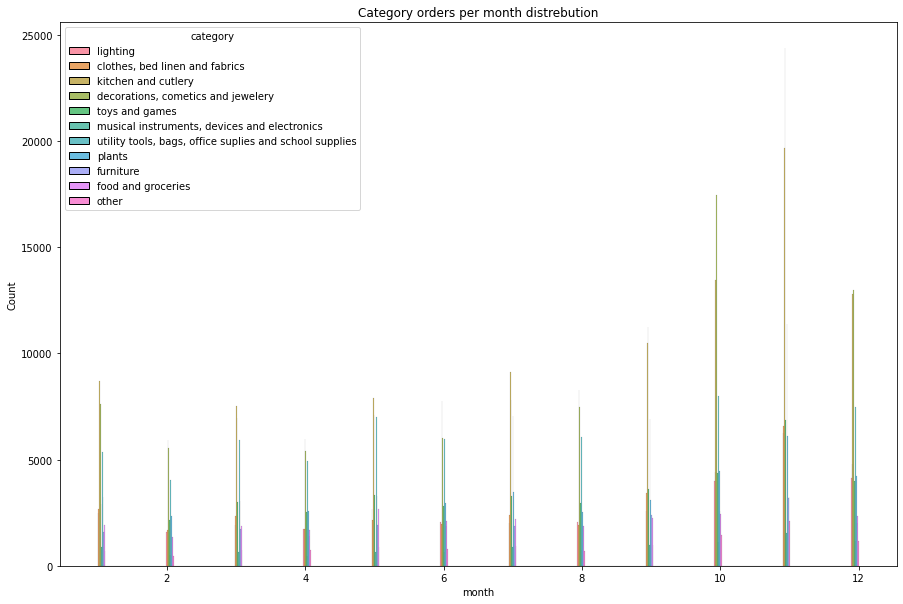

In [106]:
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots()
sns.histplot(
            data=e_com, x='month', hue ='category' , multiple='dodge',
            bins=100, ax=ax
    )
plt.title("Category orders per month distrebution")
plt.show()

<div class="alert alert-warning"> <b>Team Lead comment:</b>What kind of aggregation is this? Total units sold? Total revenue? Or just simple rows in the data? If it's just 'value counts' it may mean absolutely nothing, cause it's just rows of the data
   
</div>

too much data to notice any trands.

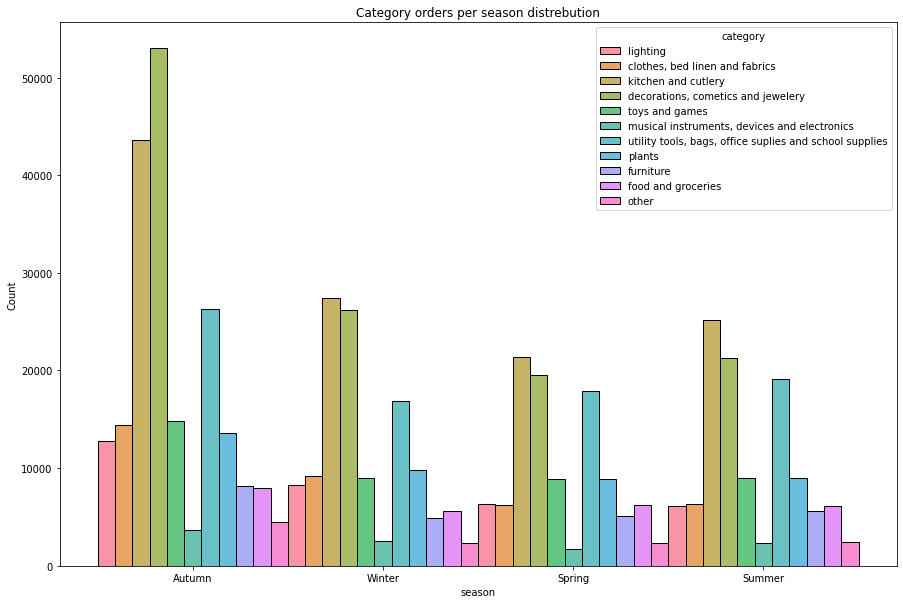

In [107]:
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots()
sns.histplot(
            data=e_com, x='season', hue ='category' , multiple='dodge',
            bins=100, ax=ax
    )
plt.title("Category orders per season distrebution")
plt.show()


 lighting 



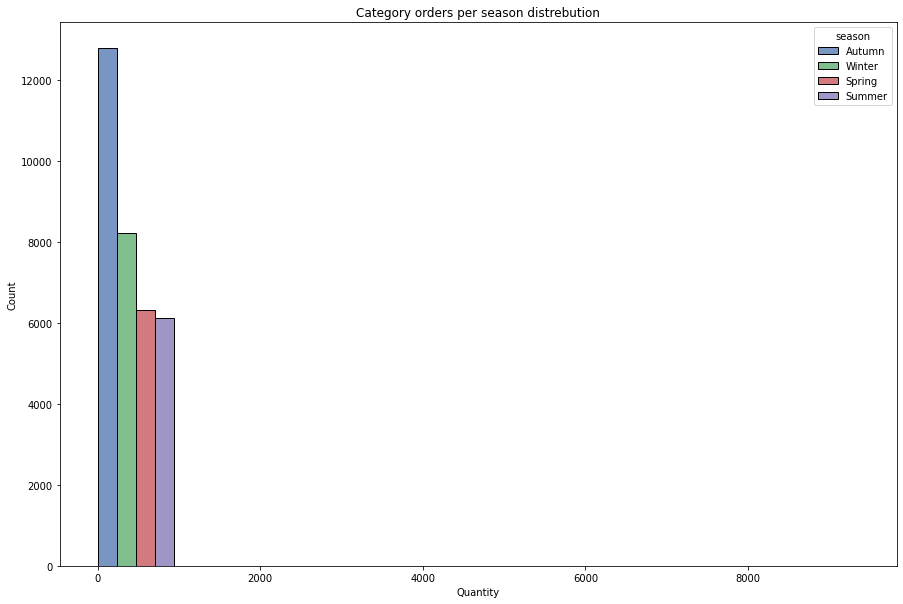


 clothes, bed linen and fabrics 



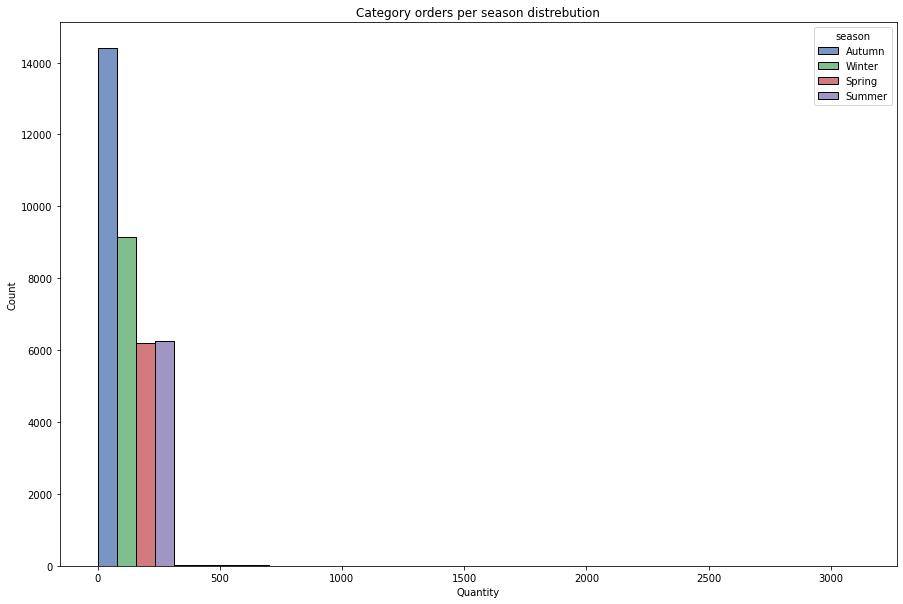


 kitchen and cutlery 



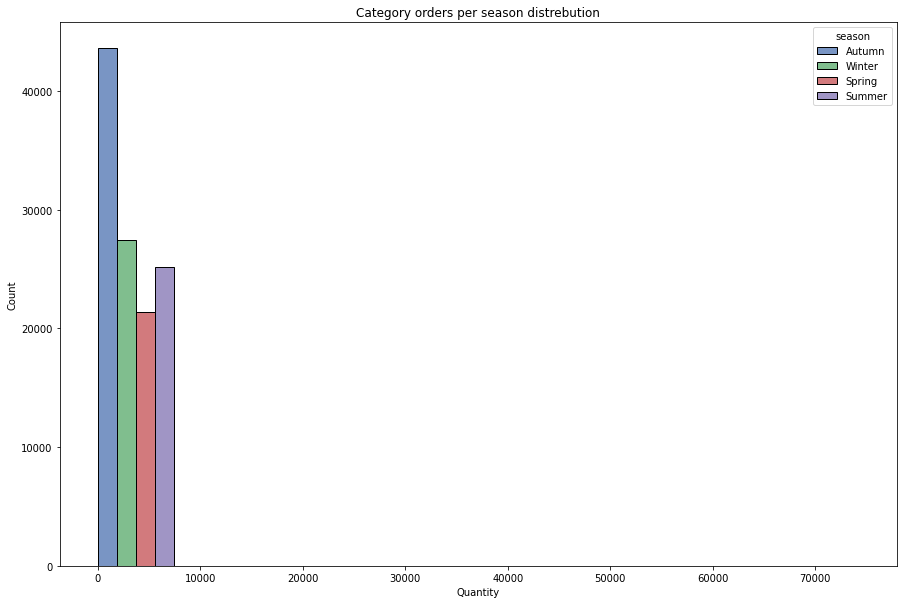


 decorations, cometics and jewelery 



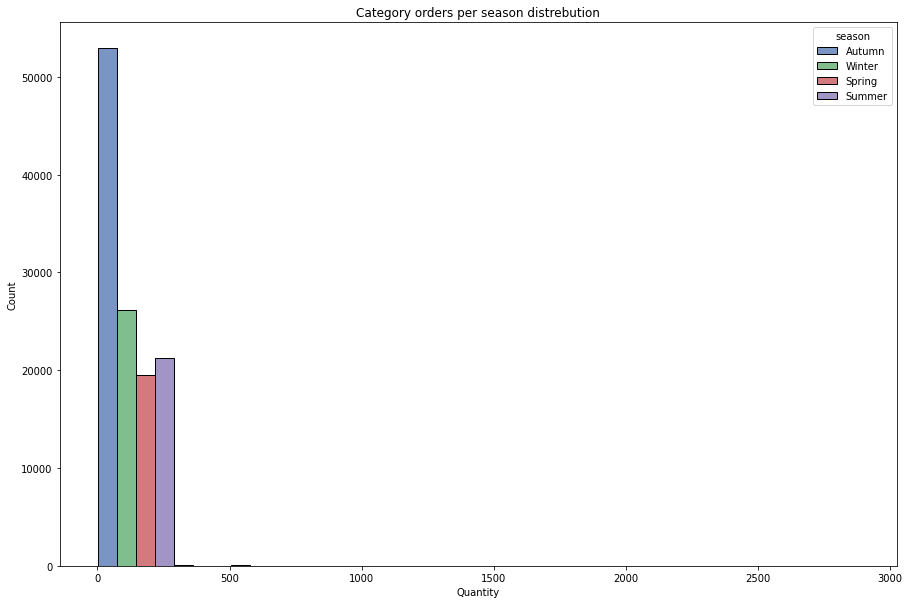


 toys and games 



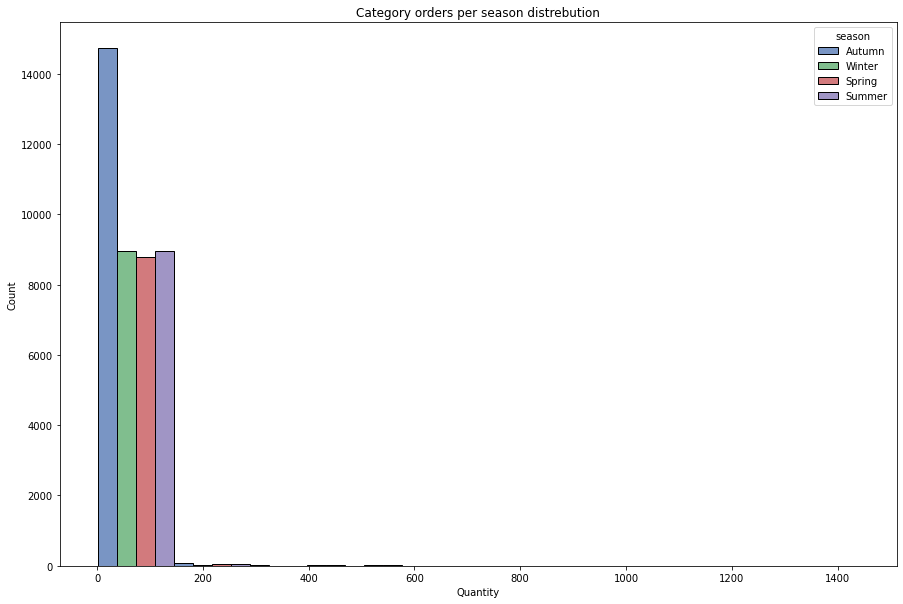


 musical instruments, devices and electronics 



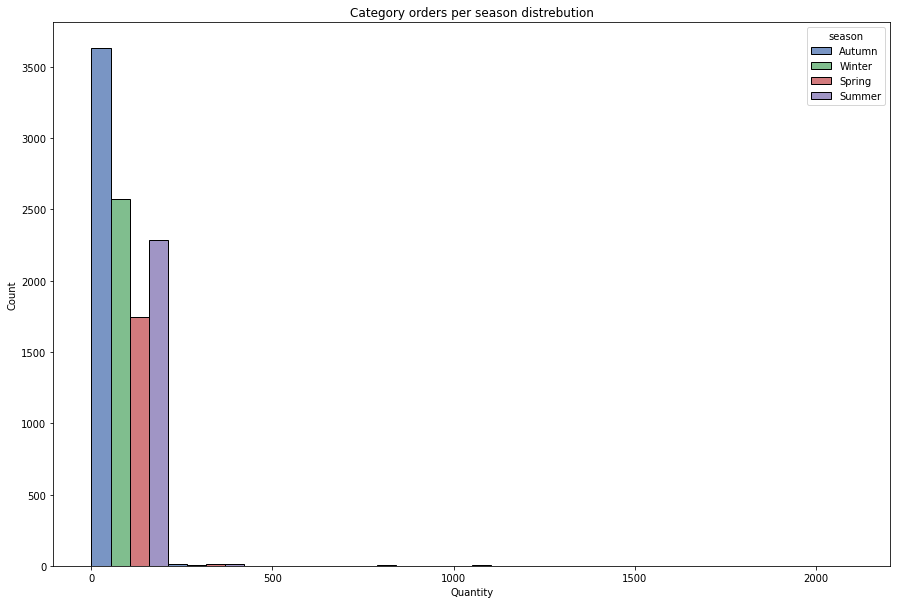


 utility tools, bags, office suplies and school supplies 



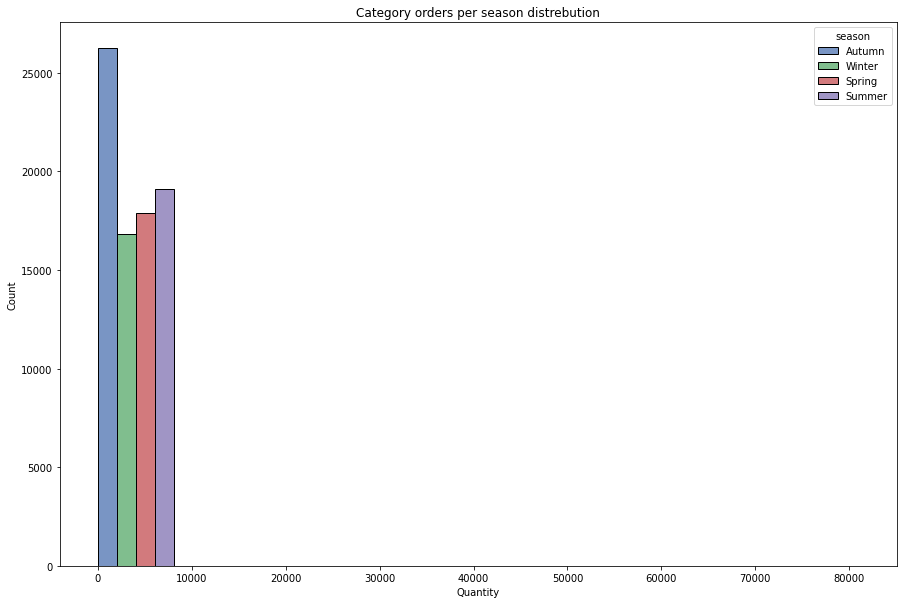


 plants 



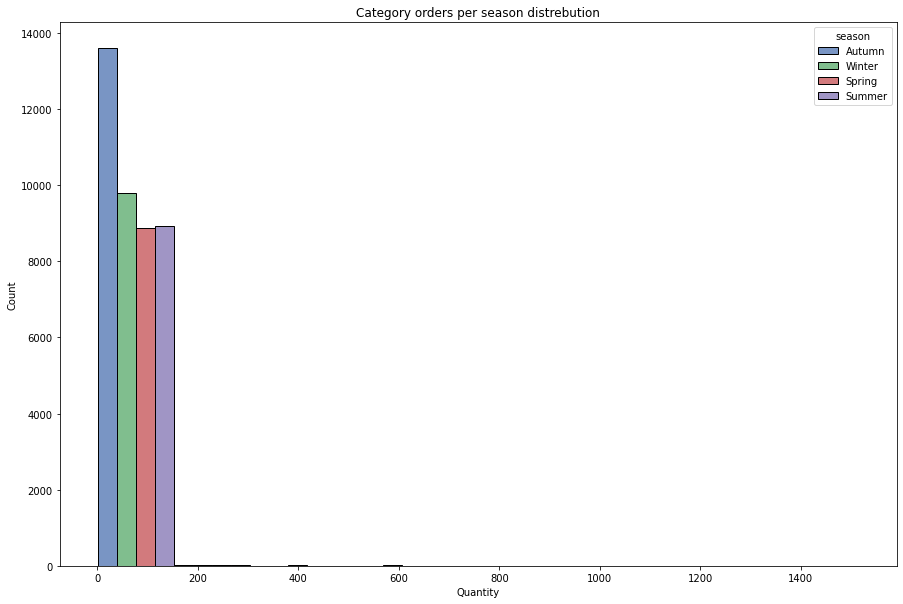


 furniture 



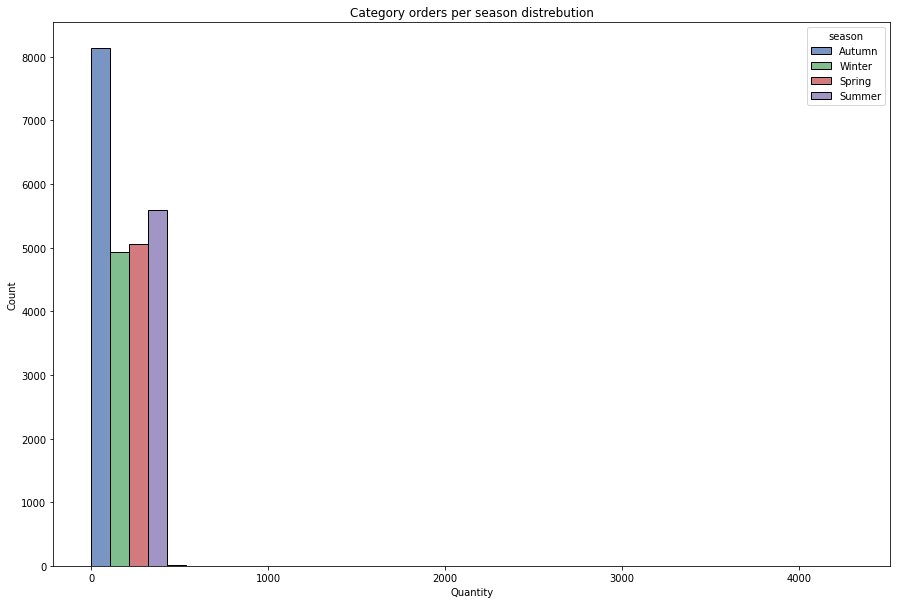


 food and groceries 



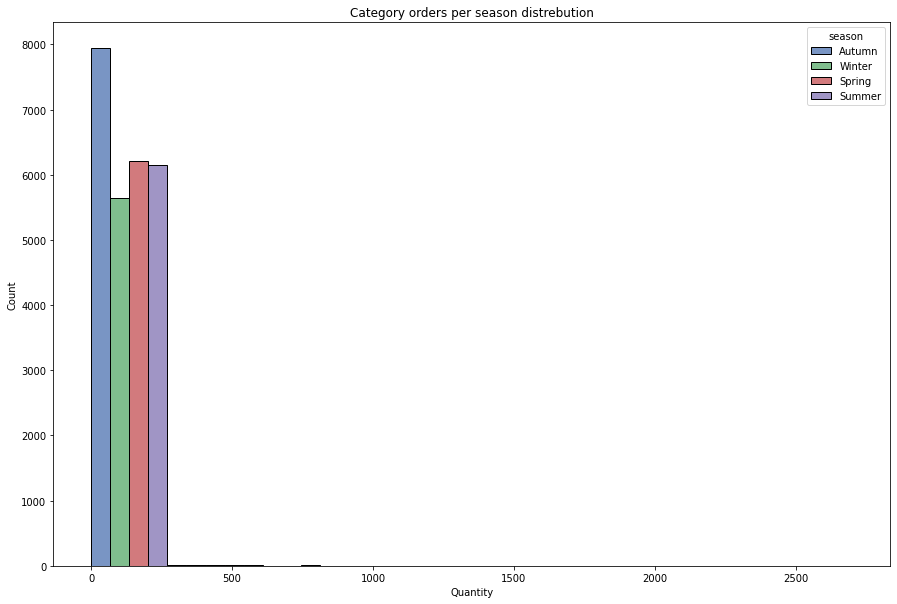


 other 



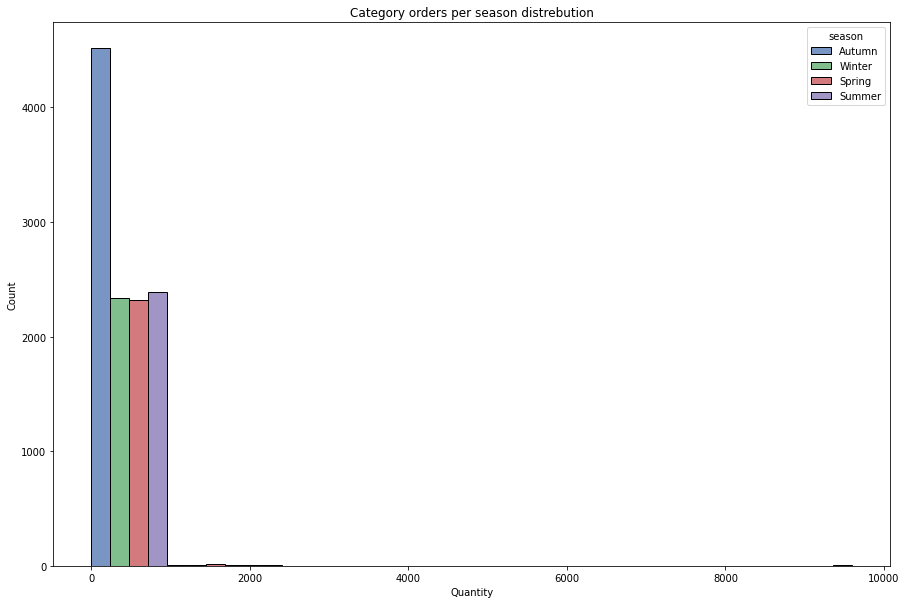

In [126]:
for i in e_com.category.unique():
    print ('\n', i, '\n')
    plt.rcParams["figure.figsize"] = (15,10)
    fig, ax = plt.subplots()
    sns.histplot(
            data=e_com[e_com.category == i], x='Quantity', hue ='season' , multiple='dodge',
            bins=10, ax=ax
    )
    plt.title("Category orders per season distrebution")
    plt.show()

In [48]:
#e_com.groupby(['category'])['InvoiceNo'].count().reset_index().sort_values(by='InvoiceNo',ascending=False)

,category,InvoiceNo
1,"decorations, cometics and jewelery",119930
4,kitchen and cutlery,117569
10,"utility tools, bags, office suplies and school supplies",80087
9,toys and games,41752
8,plants,41312
0,"clothes, bed linen and fabrics",36098
5,lighting,33483
2,food and groceries,26006
3,furniture,23755
7,other,11624


In [108]:
table1

InvoiceNo  \
month category                                                             
1     clothes, bed linen and fabrics                                 676   
      decorations, cometics and jewelery                            1029   
      food and groceries                                             651   
      furniture                                                      566   
      kitchen and cutlery                                           1121   
...                                                                  ...   
12    musical instruments, devices and electronics                   458   
      other                                                          656   
      plants                                                         977   
      toys and games                                                 950   
      utility tools, bags, office suplies and school supplies       1255   

                                                               Quantity  \
month category                                                            
1     clothes, bed linen and fabrics                              24805   
      decorations, cometics and jewelery                          62938   
      food and groceries                                          22476   
      furniture                                                   11213   
      kitchen and cutlery                                        223745   
...                                                                 ...   
12    musical instruments, devices and electronics                 8910   
      other                                                       20324   
      plants                                                      26789   
      toys and games                                              36352   
      utility tools, bags, office suplies and school supplies    231325   

                                                               UnitPrice  
month category                                                            
1     clothes, bed linen and fabrics                            9486.380  
      decorations, cometics and jewelery                       28441.250  
      food and groceries                                        6809.080  
      furniture                                                 8381.690  
      kitchen and cutlery                                      33734.440  
...                                                                  ...  
12    musical instruments, devices and electronics              4431.800  
      other                                                   105998.190  
      plants                                                   15301.850  
      toys and games                                           11408.320  
      utility tools, bags, office suplies and school supplies  65001.520  

[132 rows x 3 columns]

 #### Total units sold?

In [109]:
table1.groupby(['category'])['Quantity'].sum().reset_index().sort_values(by='Quantity',ascending=False)

,category,Quantity
4,kitchen and cutlery,1201981
1,"decorations, cometics and jewelery",1193708
10,"utility tools, bags, office suplies and school supplies",1173316
9,toys and games,483258
5,lighting,458990
7,other,345258
8,plants,327854
2,food and groceries,326414
0,"clothes, bed linen and fabrics",314110
3,furniture,216543


- kitchen and cutlery is the category with most items ordred, by quantity.

#### Avarage revenue?

In [113]:
table1.groupby(['category'])['UnitPrice'].mean().reset_index().sort_values(by='UnitPrice',ascending=False)

,category,UnitPrice
7,other,45479.091
10,"utility tools, bags, office suplies and school supplies",37634.352
4,kitchen and cutlery,35906.998
1,"decorations, cometics and jewelery",35065.338
8,plants,11537.554
0,"clothes, bed linen and fabrics",10008.938
3,furniture,9558.514
9,toys and games,8218.483
5,lighting,8100.067
2,food and groceries,7266.679


- the "other" category is the one with highest avg revenue. 

#### Orders by category?

In [112]:
table1.groupby(['category'])['InvoiceNo'].sum().reset_index().sort_values(by='InvoiceNo',ascending=False)

,category,InvoiceNo
4,kitchen and cutlery,16841
1,"decorations, cometics and jewelery",16827
10,"utility tools, bags, office suplies and school supplies",14518
8,plants,11364
5,lighting,10938
9,toys and games,10921
0,"clothes, bed linen and fabrics",9850
2,food and groceries,9452
3,furniture,8708
7,other,7284


<div class="alert alert-danger"> <b>Team Lead comment:</b> Count is an incorrect measure here. One row!= one invoice, what other aggregation technique should we use?
   
</div>

<div class="alert alert-block alert-info">
<b>Juniors answer.</b> <a class="tocSkip"></a>

Thank you, hope now it is better. 
</div>

Conclusions: 

- Automn is the best season for sales. And the categories of decor and cutlery, lead in sells (probably because black friday, chinese singles day, halloween and chinese moon festival. All occur in Automn.

- decor, cutlery and utility. Are the 3 categories leading in both number of orders and quantity ordred, more variability in those categories might prove beneficial. 

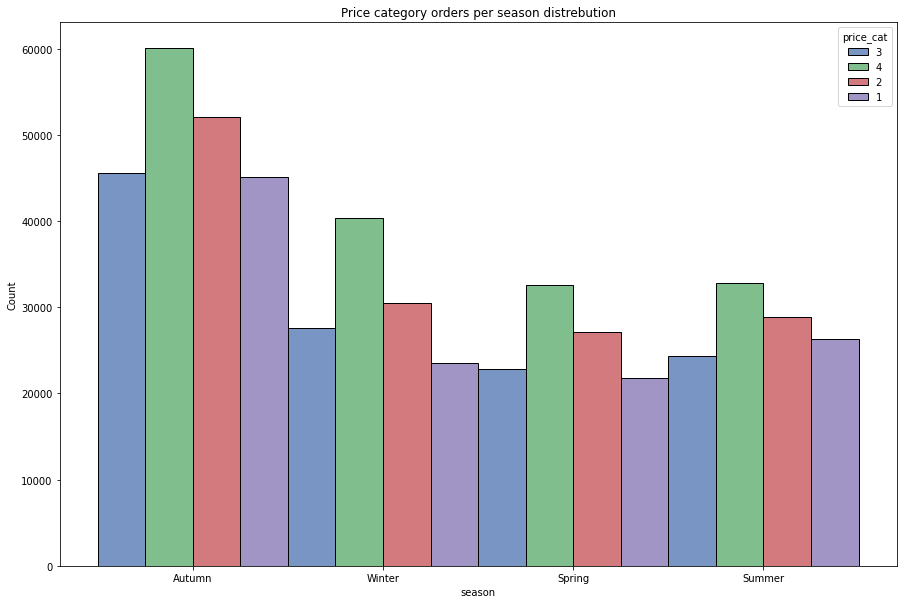

In [115]:
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots()
sns.histplot(
            data=e_com, x='season', hue ='price_cat' , multiple='dodge',
            bins=70, ax=ax
    )
plt.title("Price category orders per season distrebution")
plt.show()

In [50]:
#e_com.groupby(['price_cat'])['InvoiceNo'].count().reset_index().sort_values(by='InvoiceNo',ascending=False)

,price_cat,InvoiceNo
3,4,165972
1,2,138597
2,3,120453
0,1,116887



 lighting 



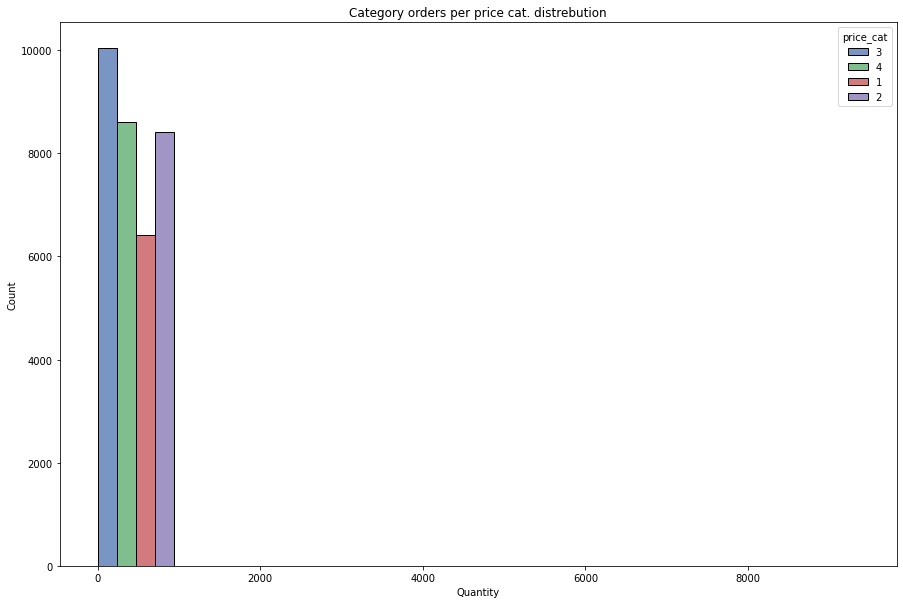


 clothes, bed linen and fabrics 



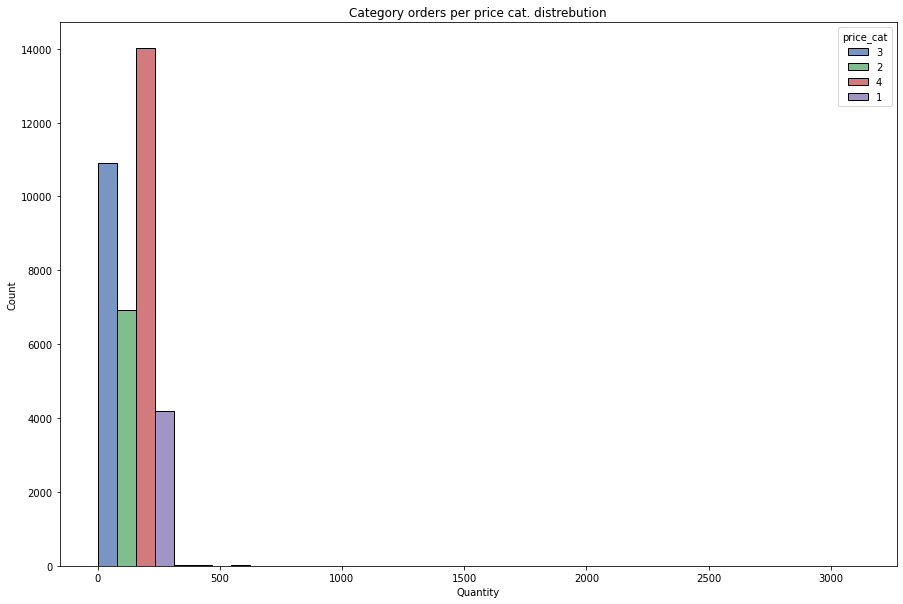


 kitchen and cutlery 



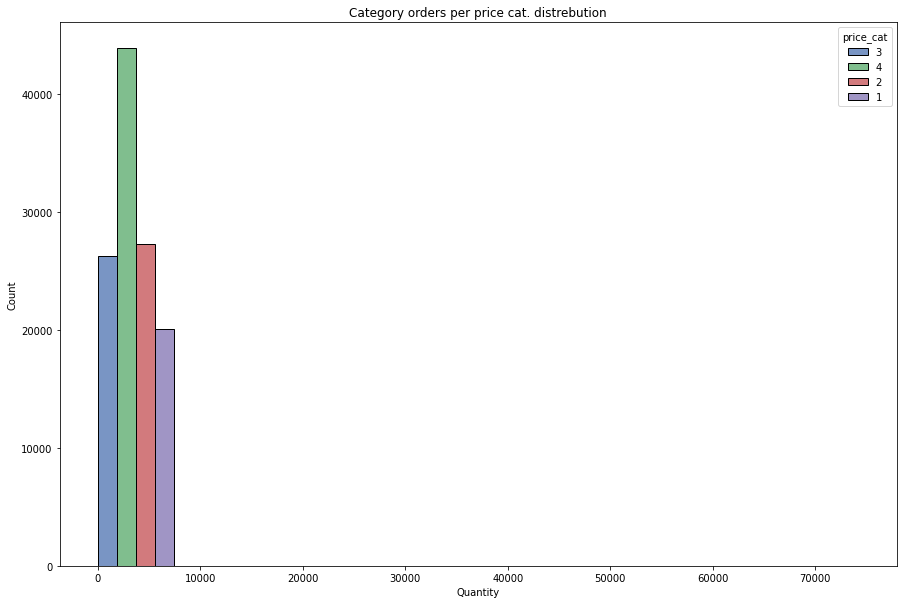


 decorations, cometics and jewelery 



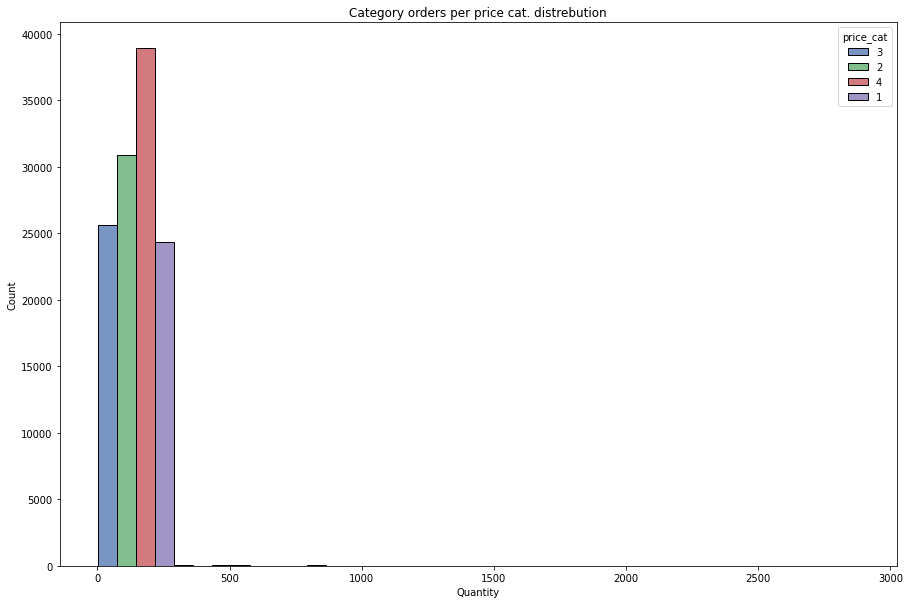


 toys and games 



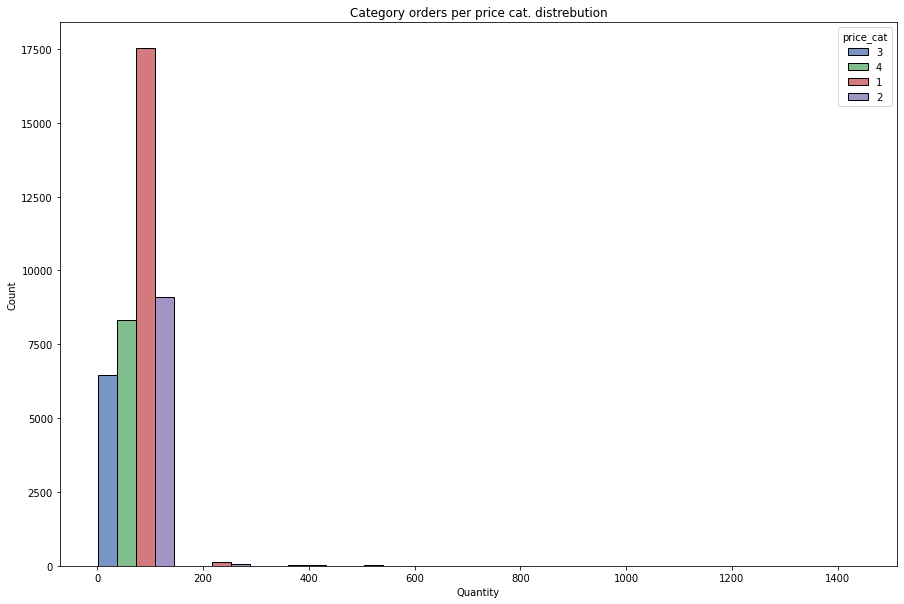


 musical instruments, devices and electronics 



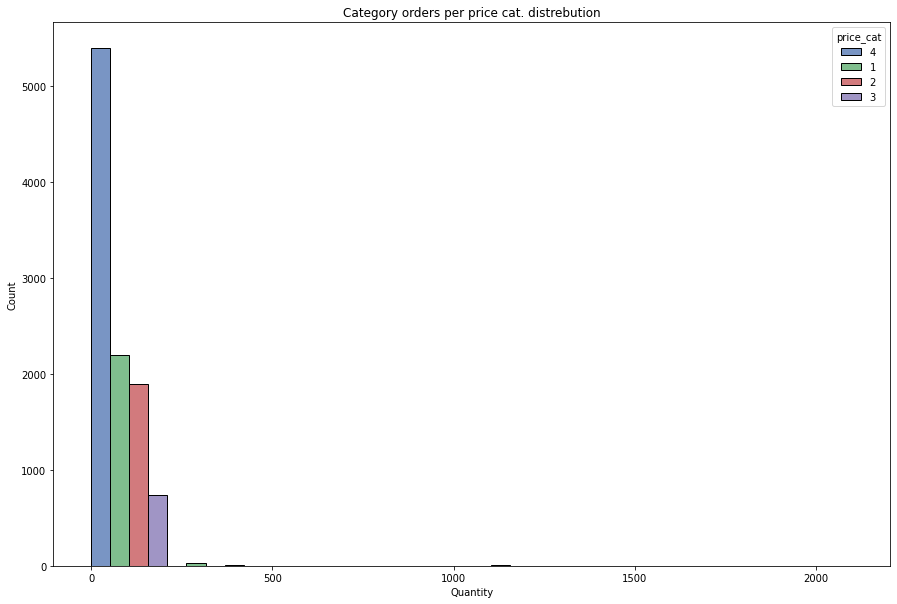


 utility tools, bags, office suplies and school supplies 



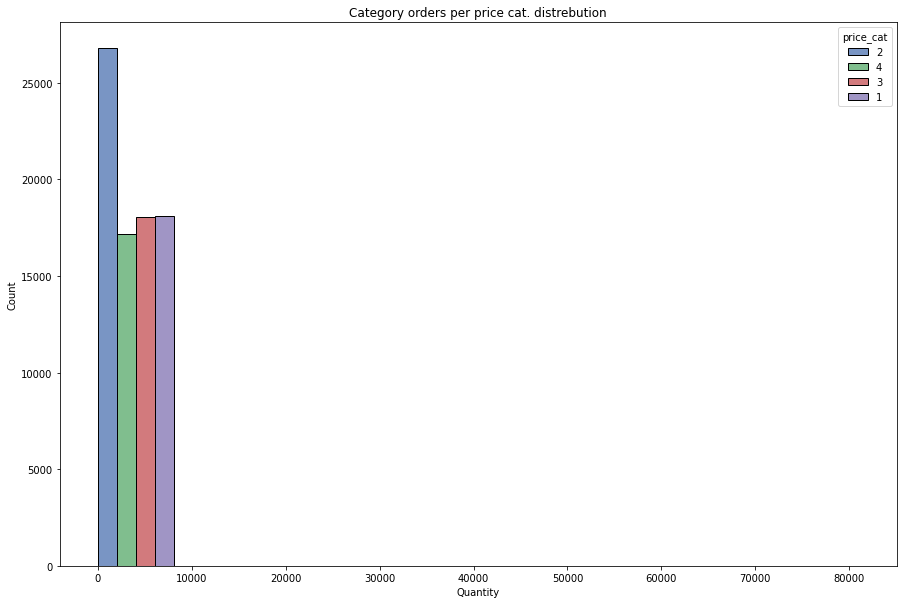


 plants 



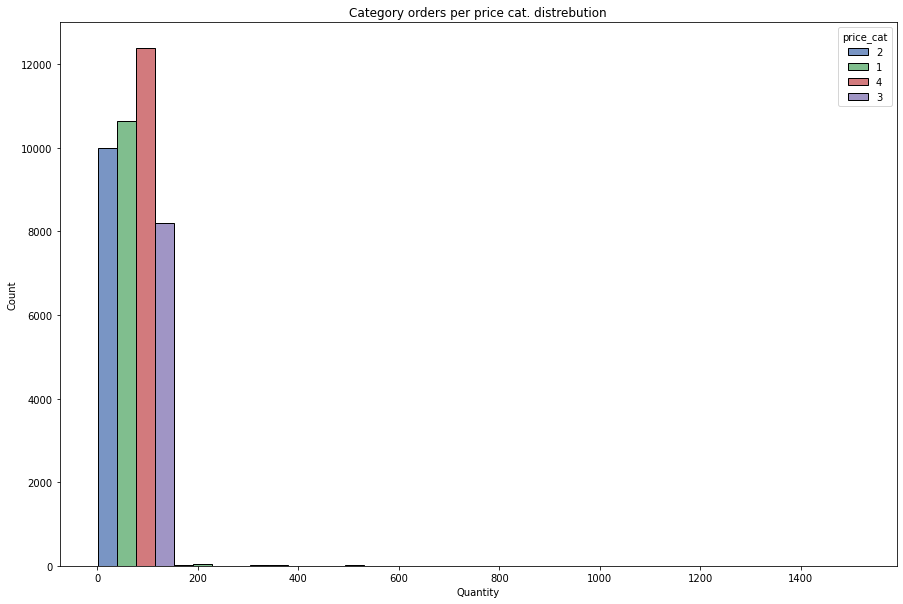


 furniture 



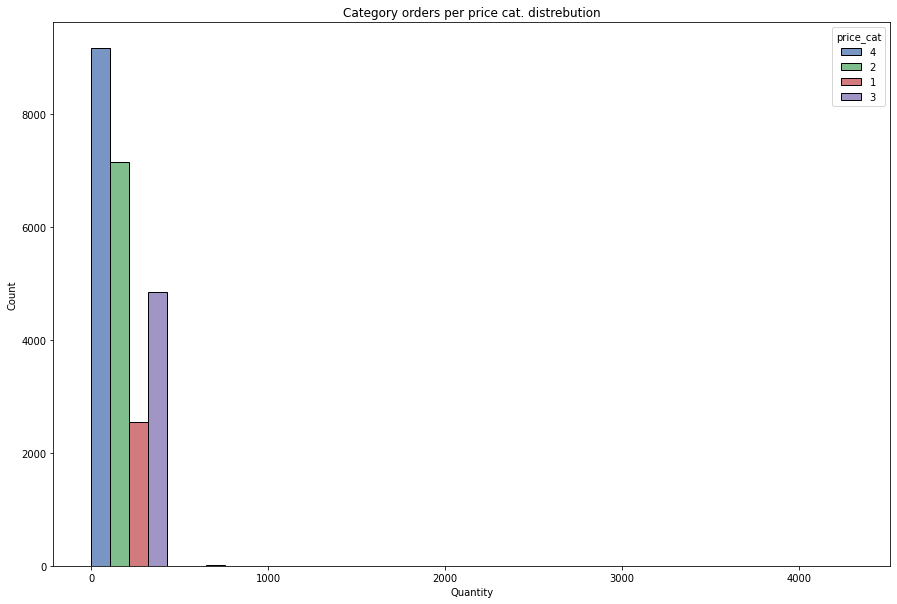


 food and groceries 



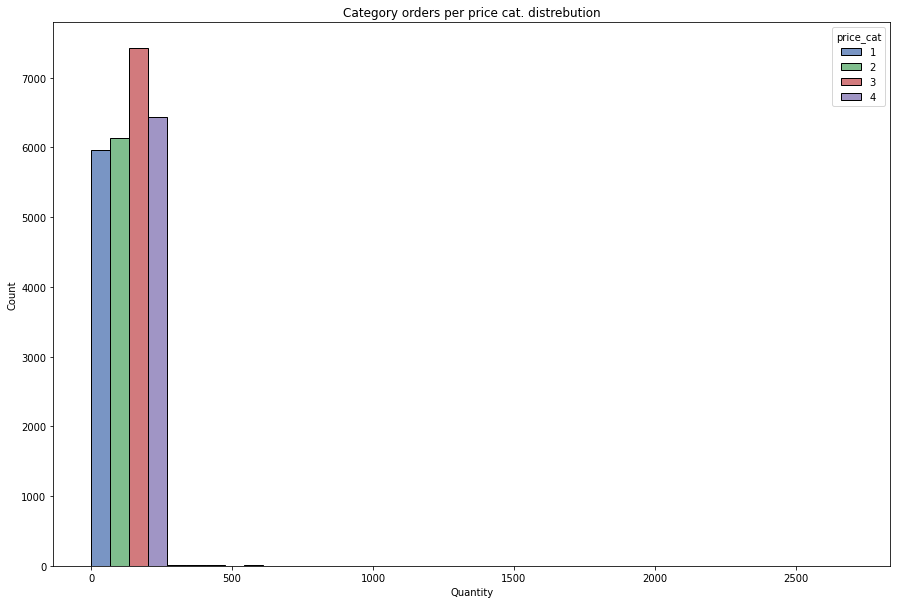


 other 



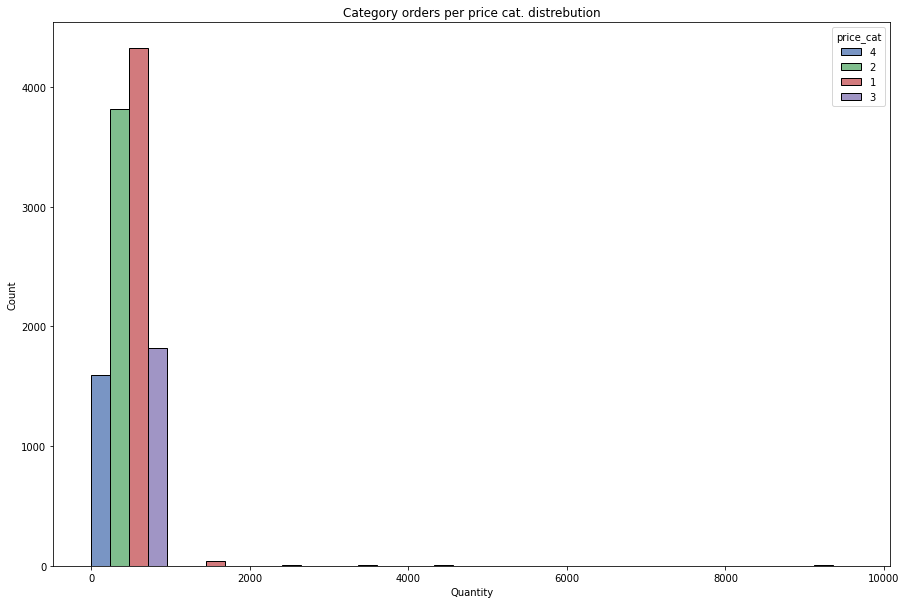

In [176]:
for i in e_com.category.unique():
    print ('\n', i, '\n')
    plt.rcParams["figure.figsize"] = (15,10)
    fig, ax = plt.subplots()
    sns.histplot(
            data=e_com[e_com.category == i], x='Quantity', hue ='price_cat' , multiple='dodge',
            bins=10, ax=ax
    )
    plt.title("Category orders per price cat. distrebution")
    plt.show()

In [117]:
table2 = pd.pivot_table(e_com, values=['Quantity', 'UnitPrice', 'InvoiceNo'], index=['price_cat', 'category'],
                    aggfunc={'Quantity': np.sum,
                             'UnitPrice': np.sum,
                            'InvoiceNo': pd.Series.nunique})
table2

InvoiceNo  \
price_cat category                                                             
1         clothes, bed linen and fabrics                                2623   
          decorations, cometics and jewelery                            7736   
          food and groceries                                            3611   
          furniture                                                     1885   
          kitchen and cutlery                                           7708   
          lighting                                                      3992   
          musical instruments, devices and electronics                  1480   
          other                                                         3699   
          plants                                                        4768   
          toys and games                                                5753   
          utility tools, bags, office suplies and school supplies       6794   
2         clothes, bed linen and fabrics                                3914   
          decorations, cometics and jewelery                           10114   
          food and groceries                                            4001   
          furniture                                                     3178   
          kitchen and cutlery                                           9446   
          lighting                                                      4794   
          musical instruments, devices and electronics                  1450   
          other                                                         2824   
          plants                                                        5107   
          toys and games                                                5273   
          utility tools, bags, office suplies and school supplies       8714   
3         clothes, bed linen and fabrics                                4955   
          decorations, cometics and jewelery                            9093   
          food and groceries                                            4066   
          furniture                                                     2826   
          kitchen and cutlery                                           8234   
          lighting                                                      5133   
          musical instruments, devices and electronics                   438   
          other                                                         1221   
          plants                                                        3931   
          toys and games                                                3455   
          utility tools, bags, office suplies and school supplies       7181   
4         clothes, bed linen and fabrics                                4941   
          decorations, cometics and jewelery                           10746   
          food and groceries                                            3316   
          furniture                                                     4867   
          kitchen and cutlery                                          11904   
          lighting                                                      4295   
          musical instruments, devices and electronics                  2463   
          other                                                         1320   
          plants                                                        5888   
          toys and games                                                4094   
          utility tools, bags, office suplies and school supplies       5737   

                                                                   Quantity  \
price_cat category                                                            
1         clothes, bed linen and fabrics                              88808   
          decorations, cometics and jewelery                         463993   
          food and groceries                                         1

 #### Total units sold?

In [121]:
table2.groupby(['price_cat'])['Quantity'].sum().reset_index().sort_values(by='Quantity',ascending=False)

,price_cat,Quantity
0,1,2797669
1,2,1605549
2,3,1063366
3,4,678928


- cheap goods are the most ordred by quantity, while luxury the least.

#### Avarage revenue?

In [120]:
table2.groupby(['price_cat'])['UnitPrice'].mean().reset_index().sort_values(by='UnitPrice',ascending=False)

,price_cat,UnitPrice
3,4,176888.662
2,3,28641.944
1,2,19067.996
0,1,6587.963


- avg revenue is highest for luxury goods, as expected.

#### Orders by category?

In [119]:
table2.groupby(['price_cat'])['InvoiceNo'].sum().reset_index().sort_values(by='InvoiceNo',ascending=False)

,price_cat,InvoiceNo
3,4,59571
1,2,58815
2,3,50533
0,1,50049


- Number of order ids is highest for luxury goods.

<div class="alert alert-danger"> <b>Team Lead comment:</b>Same problem with graphs and aggregration here
   
</div>

<div class="alert alert-block alert-info">
<b>Juniors answer.</b> <a class="tocSkip"></a>

Thank you, hope now it is better. 
</div>

Conclusions: 

- No connection between season and price category can be seen in the chart.

- There is a prefrance of either affordable or luxury goods in the order ids, but cheap goods lead by order quantity.

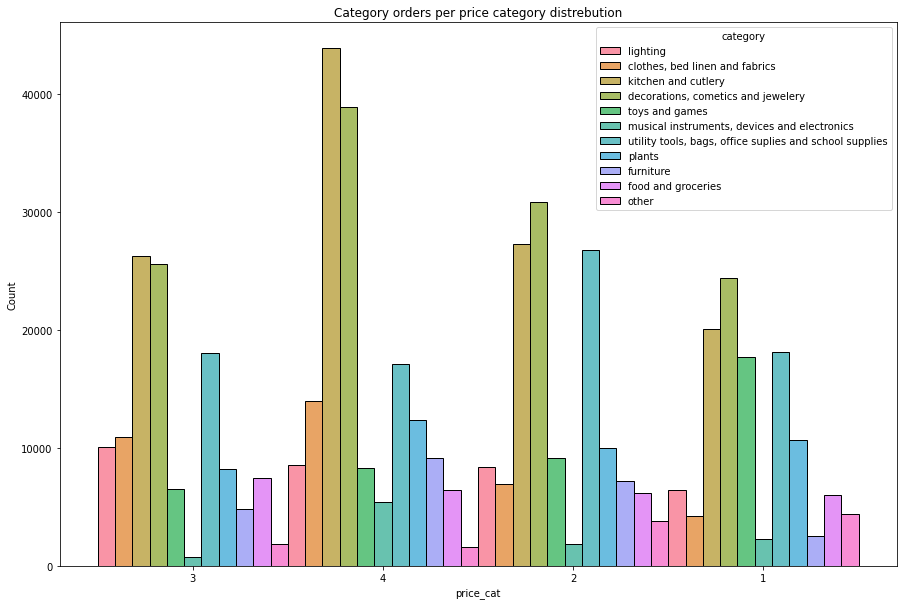

In [114]:
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots()
sns.histplot(
            data=e_com, x='price_cat', hue ='category' , multiple='dodge',
            bins=70, ax=ax
    )
plt.title("Category orders per price category distrebution")
plt.show()

Conclusions: 

- Orders of toys in the cheap price category is grater then the other categories. So higher veriaty of toys that are cheap, is probably a good idea.

- Orders of cutlery, musical instruments and electronics, clothes, plants and decor in the luxury price category is grater then the other categories. So higher veriaty of goods of these categories that are luxury, is probably a good idea.

- Musical instruments and electronics of pricey(3) price category, show very low demand so reducing amount of goods of that category and price range might free up some space in the wherehouse so to speak.   

### Step 4. check for correlatins 

In [52]:
e_com.corr()

,Quantity,UnitPrice,CustomerID,month
Quantity,1.000,-0.002,-0.005,-0.002
UnitPrice,-0.002,1.000,-0.005,-0.000
CustomerID,-0.005,-0.005,1.000,0.030
month,-0.002,-0.000,0.030,1.000


<AxesSubplot:>

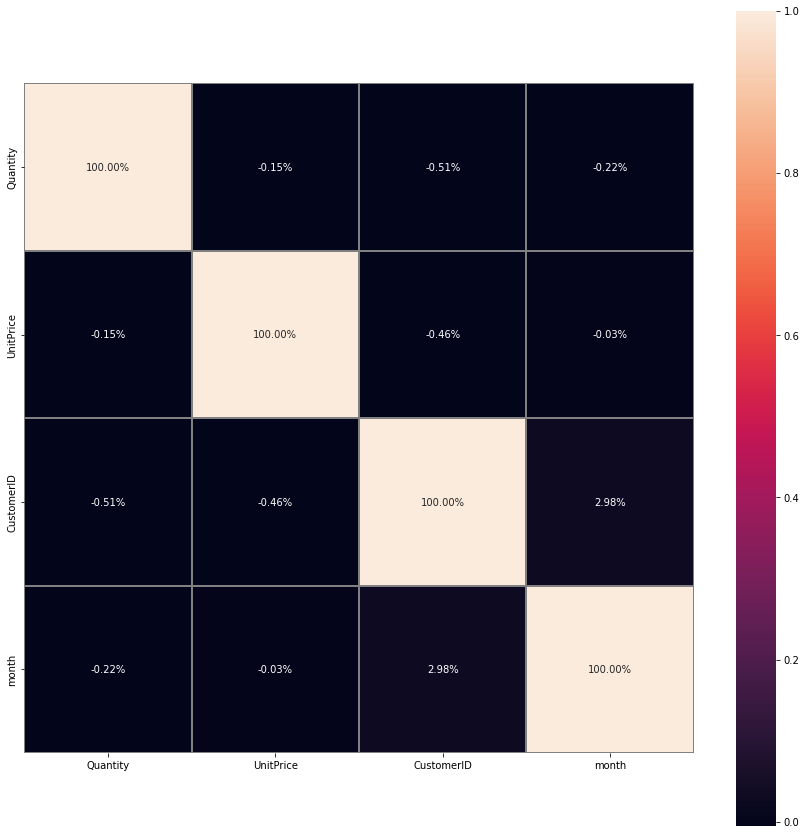

In [53]:
plt.figure(figsize = (15,15))
sns.heatmap(e_com.corr(), annot=True, square = True, fmt='.2%', linewidths=1, linecolor='grey')

Conclusions: 


- Heat map shows weak negative correlation between UnitPrice and Quantity, so stocking more luxury items might be a good idea. 

- Privious charts show damnd for cutlery, musical instruments and electronics, clothes, and decor in the luxury price category is grater then the other categories. So higher veriaty of goods of these categories that are luxury, is probably a good idea.  

## Statistical analysis

### Step 1. cheaper pruducts have better sells online then more costly ones

In [127]:
e_com['date'] = (pd.DatetimeIndex(e_com['InvoiceDate']).date)
e_com.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,category,price_cat,month,season,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.550,17850.000,lighting,3,11,Autumn,2018-11-29
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.390,17850.000,lighting,3,11,Autumn,2018-11-29
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.750,17850.000,"clothes, bed linen and fabrics",3,11,Autumn,2018-11-29
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.390,17850.000,kitchen and cutlery,3,11,Autumn,2018-11-29
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.390,17850.000,"decorations, cometics and jewelery",3,11,Autumn,2018-11-29


In [128]:
e_cheap = e_com.query('UnitPrice < 3').groupby('date')['InvoiceNo'].count().reset_index().sort_values(by='InvoiceNo',ascending=False)
e_cheap.head()

,date,InvoiceNo
300,2019-12-03,3329
303,2019-12-06,3032
280,2019-11-09,2768
284,2019-11-14,2744
295,2019-11-27,2695


In [129]:
e_costly = e_com.query('UnitPrice > 3').groupby('date')['InvoiceNo'].count().reset_index().sort_values(by='InvoiceNo',ascending=False)
e_costly.head()

,date,InvoiceNo
300,2019-12-03,2002
303,2019-12-06,1908
14,2018-12-15,1662
4,2018-12-04,1632
270,2019-10-29,1619


**specify H0, H1 and significance level**
 
 **H0:** π₁ = π₂, There is no significant difference between the groups. This means the amount of orders is not significantly different between the groups, and not dependant on cost.
 
 **H1:**  π₁ != π₂, There is a significant difference between the groups. This means the amount of orders is significantly different between the groups, and is prabably dependant on cost.
 
 **significance level:** 0.05, The probability of making a type I error is equal to the significance level, α.
 A type II error is a false negative result. This means there is difference between the groups, but the test yielded a p-value  greater than α. You can't have an arbitrarily low probability of making a type I error and an arbitrarily low probability of making a type II error; there is a tradeoff between the two in any hypothesis test, by choosing a significance level of 1% or 5%, we can strike a good balance between the two.

In [130]:
def testing_average(sample1,sample2,alpha=0.05):
    #checking normality
    sample1=sample1.dropna()
    sample2=sample2.dropna()
    stat1, p1_norm=st.shapiro(sample1)
    stat2, p2_norm=st.shapiro(sample2)
    if p1_norm > alpha and p2_norm > alpha:
        #then both normal, perform t-test.
        #for t-test also should check the equality of variances
        statslev,p_levene=st.levene(sample1, sample2)
        if p_levene<alpha:
           #variances are not equal
            statist,p_value=st.ttest_ind(sample1, sample2,equal_var=False)
            u_test = "t-test var not equal"
        else:
            statist,p_value=st.ttest_ind(sample1, sample2,equal_var=True) 
            u_test = "t-test var equal"
    else:
        statist,p_value=st.mannwhitneyu(sample1, sample2)
        u_test = "Mann–Whitney U"
    print(p_value)
    if p_value<alpha:
        print('Reject H0')
    else:
        print('Fail to Reject H0')
    print(u_test)

In [131]:
testing_average(e_cheap.InvoiceNo, e_costly.InvoiceNo, alpha=0.05)

9.801327766799242e-51
Reject H0
Mann–Whitney U


We reject H0 using significance level 0.05, There is a significant difference between the groups.

<div class="alert alert-warning"> <b>Team Lead comment:</b> Please check the aggregation method and re-do the tests
   
</div>

In [132]:
e_cheap.InvoiceNo.mean() > e_costly.InvoiceNo.mean()

True

**Conclusion:** cheaper pruducts probably have better sells online then more costly ones.

### Step 2. sells of  product types differ in seasons (toys and blankets in winter, ornaments in spring,  towels and air fans in summer, tea mugs in automn. or something of the sort)

In [133]:
pivot= e_com.query('category != "other"').pivot_table(index='category', columns='season',values='InvoiceNo',aggfunc='nunique').reset_index()
pivot

season,category,Autumn,Spring,Summer,Winter
0,"clothes, bed linen and fabrics",3681,2034,1894,2241
1,"decorations, cometics and jewelery",6183,3575,3552,3517
2,food and groceries,2964,2288,2256,1944
3,furniture,2980,1927,2028,1773
4,kitchen and cutlery,5787,3651,3739,3664
5,lighting,3951,2314,2232,2441
6,"musical instruments, devices and electronics",1630,923,1050,1033
7,plants,3927,2551,2564,2322
8,toys and games,3732,2509,2406,2274
9,"utility tools, bags, office suplies and school supplies",4980,3352,3240,2946


####  Bonferonni Correction

In [134]:
# 4 dependent statistical tests (4 seasons)
alpha = 0.05
nu_alpha = alpha/4
nu_alpha 

0.0125

In [135]:
e_su = e_com.query('season == "Summer"')
sample1 =e_su[e_su.category == 'lighting'].groupby('date')['InvoiceNo'].count().reset_index().sort_values(by='InvoiceNo',ascending=False)
sample1

,date,InvoiceNo
74,2019-08-28,195
77,2019-08-31,151
38,2019-07-16,131
3,2019-06-05,125
4,2019-06-06,122
...,...,...
21,2019-06-26,45
63,2019-08-14,42
72,2019-08-24,34
25,2019-07-01,25


In [136]:
e_au = e_com.query('season == "Autumn"')
sample2 = e_au[e_au.category == 'lighting'].groupby('date')['InvoiceNo'].count().reset_index().sort_values(by='InvoiceNo',ascending=False)
sample2

,date,InvoiceNo
61,2019-11-09,306
65,2019-11-14,295
76,2019-11-27,294
71,2019-11-21,283
70,2019-11-20,282
...,...,...
3,2019-09-03,63
21,2019-09-24,57
4,2019-09-04,56
2,2019-09-02,55


In [137]:
#sample to check posibility
testing_average(sample2.InvoiceNo, sample1.InvoiceNo, alpha=nu_alpha)

1.2029452330221295e-16
Reject H0
Mann–Whitney U


**specify H0, H1 and significance level**
 
 **H0:** π₁ = π₂, There is no significant difference between the groups. This means the amount of orders is not significantly different between the groups, and not dependant on season.
 
 **H1:**  π₁ != π₂, There is a significant difference between the groups. This means the amount of orders is significantly different between the groups, and is prabably dependant on season.
 
 **significance level:** 0.05, The probability of making a type I error is equal to the significance level, α.
 A type II error is a false negative result. This means there is difference between the groups, but the test yielded a p-value  greater than α. You can't have an arbitrarily low probability of making a type I error and an arbitrarily low probability of making a type II error; there is a tradeoff between the two in any hypothesis test, by choosing a significance level of 1% or 5%, we can strike a good balance between the two.

In [138]:
def check_hypothesis(group1,group2,cat,alpha=0.05):
    sample1 = group1[group1.category == cat].groupby('date')['InvoiceNo'].count().reset_index().sort_values(by='InvoiceNo',ascending=False).InvoiceNo
    sample2 = group2[group2.category == cat].groupby('date')['InvoiceNo'].count().reset_index().sort_values(by='InvoiceNo',ascending=False).InvoiceNo
    # same as checking_avarage function
    stat1, p1_norm=st.shapiro(sample1)
    stat2, p2_norm=st.shapiro(sample2)
    if p1_norm > alpha and p2_norm > alpha:
        #then both normal, perform t-test.
        #for t-test also should check the equality of variances
        statslev,p_levene=st.levene(sample1, sample2)
        if p_levene<alpha:
           #variances are not equal
            statist,p_value=st.ttest_ind(sample1, sample2,equal_var=False)
            u_test = "t-test var not equal"
        else:
            statist,p_value=st.ttest_ind(sample1, sample2,equal_var=True) 
            u_test = "t-test var equal"
    else:
        statist,p_value=st.mannwhitneyu(sample1, sample2)
        u_test = "Mann–Whitney U"
    print(p_value)
    if (p_value < alpha):
        print("Rejecting the null hypothesis for", cat,"at seasons", group1.season.iloc[0], "and", group2.season.iloc[0])
    else:
        print("Failed to reject the null hypothesis for",cat,"at seasons", group1.season.iloc[0], "and", group2.season.iloc[0])
    print(u_test)

In [139]:
for w in e_com.season.unique():
    e_com_y = e_com[e_com.season == w]    
    e_com_n = e_com[e_com.season != w]
    for j in e_com_n.season.unique():
        print ('\n', j, "and", w, '\n')
        for i in pivot.category.unique():
            check_hypothesis(e_com[e_com.season == j], e_com_y, i, alpha=nu_alpha)


 Winter and Autumn 

8.09912497502049e-09
Rejecting the null hypothesis for clothes, bed linen and fabrics at seasons Winter and Autumn
Mann–Whitney U
9.462601442172193e-15
Rejecting the null hypothesis for decorations, cometics and jewelery at seasons Winter and Autumn
Mann–Whitney U
1.4533109504745231e-06
Rejecting the null hypothesis for food and groceries at seasons Winter and Autumn
Mann–Whitney U
8.759196025966485e-13
Rejecting the null hypothesis for furniture at seasons Winter and Autumn
Mann–Whitney U
1.4150045068038016e-09
Rejecting the null hypothesis for kitchen and cutlery at seasons Winter and Autumn
Mann–Whitney U
3.6453211366885934e-07
Rejecting the null hypothesis for lighting at seasons Winter and Autumn
Mann–Whitney U
3.9389036582782266e-05
Rejecting the null hypothesis for musical instruments, devices and electronics at seasons Winter and Autumn
Mann–Whitney U
4.5506034864629895e-05
Rejecting the null hypothesis for plants at seasons Winter and Autumn
Mann–Whitney 

Conclusions:

- Rejecting the null hypothesis for all categories and any and all seasons vs autumn, autumn is like no other season (it is special it seams...). 

-  Failed to reject the null hypothesis for most categories (all but fabrics, cutlery and devices) at seasons Spring and Winter, so ordering habits are for other categories seam very similar in those 2 seasons.

- Failed to reject the null hypothesis for most categories (all but fabrics and lighting) at seasons Summer and Winter, so ordering habits are for other categories seam very similar in those 2 seasons.

- Rejecting the null hypothesis for musical instruments, devices and electronics at seasons Spring and Summer, Failed to reject the null hypothesis for all other categories of these seasons so orders of other categories in those seasons are probably very similar.

### Step 3. Create clusters based on keywords in product description (by Kmeans) and see what defines each cluster 

#### 3.1 build a matrix of distances based on the standardized feature matrix and plot a dendrogram

In [140]:
text1 = e_com.Description.str.lower()
#text1 = lemmas_list_all
text1 

0          white hanging heart t-light holder
1                         white metal lantern
2              cream cupid hearts coat hanger
3         knitted union flag hot water bottle
4              red woolly hottie white heart.
                         ...                 
541904            pack of 20 spaceboy napkins
541905           children's apron dolly girl 
541906          childrens cutlery dolly girl 
541907        childrens cutlery circus parade
541908          baking set 9 piece retrospot 
Name: Description, Length: 541909, dtype: object

In [141]:
#Remove stopwords, punctuation and numbers
text2 = [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        for x in text1]
text2

['white hanging heart tlight holder',
 'white metal lantern',
 'cream cupid hearts coat hanger',
 'knitted union flag hot water bottle',
 'red woolly hottie white heart',
 'set  babushka nesting boxes',
 'glass star frosted tlight holder',
 'hand warmer union jack',
 'hand warmer red polka dot',
 'assorted colour bird ornament',
 'poppys playhouse bedroom',
 'poppys playhouse kitchen',
 'feltcraft princess charlotte doll',
 'ivory knitted mug cosy',
 'box  assorted colour teaspoons',
 'box vintage jigsaw blocks',
 'box vintage alphabet blocks',
 'home building block word',
 'love building block word',
 'recipe box metal heart',
 'doormat new england',
 'jam making set jars',
 'red coat rack paris fashion',
 'yellow coat rack paris fashion',
 'blue coat rack paris fashion',
 'bath building block word',
 'alarm clock bakelike pink',
 'alarm clock bakelike red',
 'alarm clock bakelike green',
 'panda bunnies sticker sheet',
 'stars gift tape',
 'inflatable political globe',
 'vintage head

In [142]:
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

text3 = pd.Series([stemSentence(x) for x in text2])
text3

0          white hang heart tlight holder
1                     white metal lantern
2           cream cupid heart coat hanger
3         knit union flag hot water bottl
4            red woolli hotti white heart
                       ...               
541904               pack spaceboy napkin
541905          children apron dolli girl
541906        children cutleri dolli girl
541907       children cutleri circu parad
541908            bake set piec retrospot
Length: 541909, dtype: object

In [143]:
#Bag of words
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(text3)


In [144]:
#matrix = pd.concat([text1,pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names())],axis=1)
#result['cluster'] = kmeans.predict(X_cv)
#matrix.head()

Kernel dies for some breason when this is run, so...

In [145]:
#Test increments of clusters using elbow method
sse={}
for k in range(1,20,1):
    kmeans = KMeans(n_clusters=k, max_iter=300).fit(X_cv)
    sse[k] = kmeans.inertia_


In [146]:
sse

{1: 2099704.2272373624,
 2: 2036172.968250452,
 3: 1997135.013357093,
 4: 1933541.493156708,
 5: 1917141.194230361,
 6: 1882729.1689513884,
 7: 1847974.7677968354,
 8: 1828702.4052970777,
 9: 1814063.4850335086,
 10: 1793960.3475583142,
 11: 1782118.2879760237,
 12: 1748226.6778748005,
 13: 1731081.069746012,
 14: 1729395.5852842033,
 15: 1711998.0558851855,
 16: 1686065.05944673,
 17: 1679572.4688584332,
 18: 1675544.1485192196,
 19: 1671266.9542105927}

3 or 6 may be a good amount of clusters

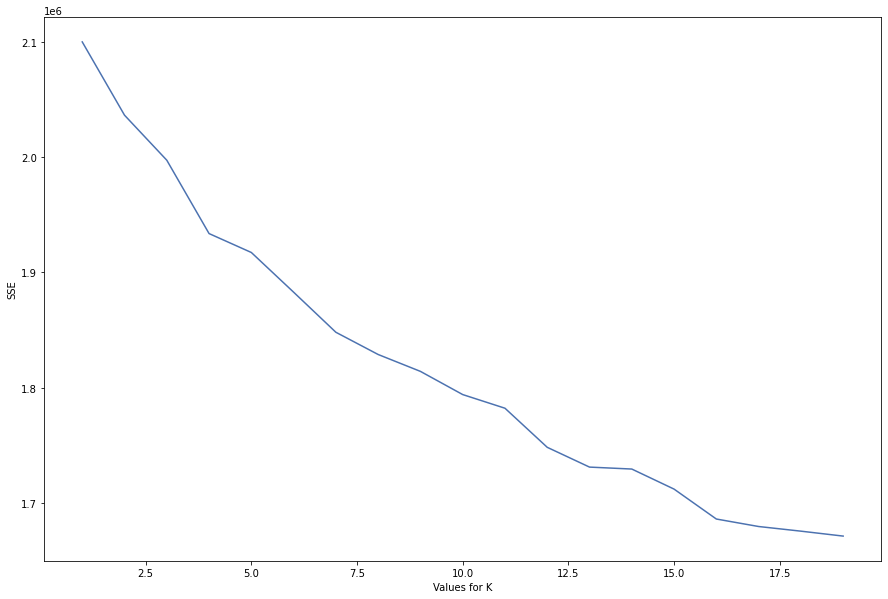

In [147]:
plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show();


The "sharpest" elbow point seams to be at 6.

In [148]:
# Use silhouette coefficient to determine the best number of clusters
#for n_cluster in range(2,14,1):
#    kmeans = KMeans(n_clusters = n_cluster).fit(X_cv)
    
#    silhouette_avg = silhouette_score(
#        X_cv, 
#        kmeans.labels_)
    
#    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

<div class="alert alert-danger"> <b>Team Lead comment:</b>Let's double-check it with silhoute score. 11 seems to be too much
   
</div>

<div class="alert alert-block alert-info">
<b>Juniors answer.</b> <a class="tocSkip"></a>

Thank you, but the Silhouette Score thing gets the system stuck for more then 20 min (I've waited 20 min) so I'll try 3, it also seames avalid option judging by sse. 
</div>

In [163]:
e_com_lite = e_com.drop(['Description', 'StockCode', 'InvoiceDate', 'date', 'season', 'CustomerID', 'InvoiceNo'], axis=1)
not_categorical = e_com_lite.drop(['category'], axis=1)
categorical = e_com_lite.category

In [164]:
#Create 3 clusters

#kmeans = KMeans(n_clusters=3)
#kmeans.fit(X_cv)
#result = pd.concat([text1,pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names())],axis=1)
#result['cluster'] = kmeans.predict(X_cv)


Should have worked but just killes the kernel...

In [165]:
# obligatory standardization of data before passing it to the algorithm
X = pd.concat([not_categorical] + [pd.get_dummies(categorical)], axis = 1)
#X.head()
sc = StandardScaler()
x_sc = sc.fit_transform(X)
#linked = linkage(x_sc, method = 'ward') 

Error: After running linkage() python kernel dies. noting  helpes...
So only small sample, instead of full df

In [152]:
x_sc = sc.fit_transform(X.sample(10000))
linked = linkage(x_sc, method = 'ward') 

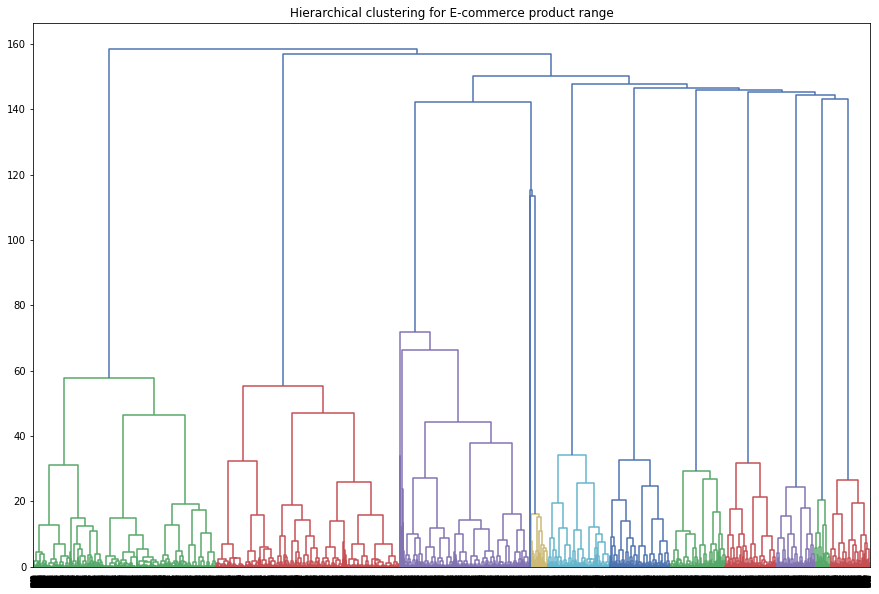

In [153]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for E-commerce product range')
plt.show()

**Conclusions:**

The dendogram showed that optimal number of clusters is 11 .

#### 3.2 Train the clustering model with the K-means algorithm and predict product clusters.

In [154]:
#Label each cluster with the word(s) that goods have in common

#clusters = result['cluster'].unique()
#labels = []
#for i in range(len(clusters)):
#    subset = result[result['cluster'] == clusters[i]]
#    words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='Name' and x!='cluster' and len(x.split()) == 1])
#    labels.append(words)
#labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
#result_labelled = pd.merge(result,labels_table,on='cluster',how='left')


good on paper but... only if the thing before would have worked.

In [166]:
# define the k_means model with 3 clusters (The dendogram showed that optimal number of clusters is 11, but sse showed otherwise) 
km = KMeans(n_clusters = 3)

x_sc = sc.fit_transform(X)
# predict the clusters for observations (the algorithm assigns them a number from 0 to 2)
labels = km.fit_predict(x_sc)

# store cluster labels in the field of our dataset
X['cluster_km'] = labels
#print(gym.cluster_km.head())

#print(X.groupby('cluster_km').mean())

#### 3.3 Plot distributions of features for the clusters, to see what defines each cluster

In [167]:
#Visualise sizes of categories (manually added to result_labelled) and clean clusters

#result_summary = pd.pivot_table(result_labelled,index=['label','category'],values=['Name'],aggfunc='count').reset_index().rename(columns={'Name':'count'})
#result_treemap = result_summary[(result_summary['label'] != '') & (result_summary['count'] > 1)]
#fig = px.treemap(result_treemap,path=['category','label'],values='count')
#fig.show();


would have worked if 3.3.2 worked...

Numerical Featurs: 
 Quantity distribution


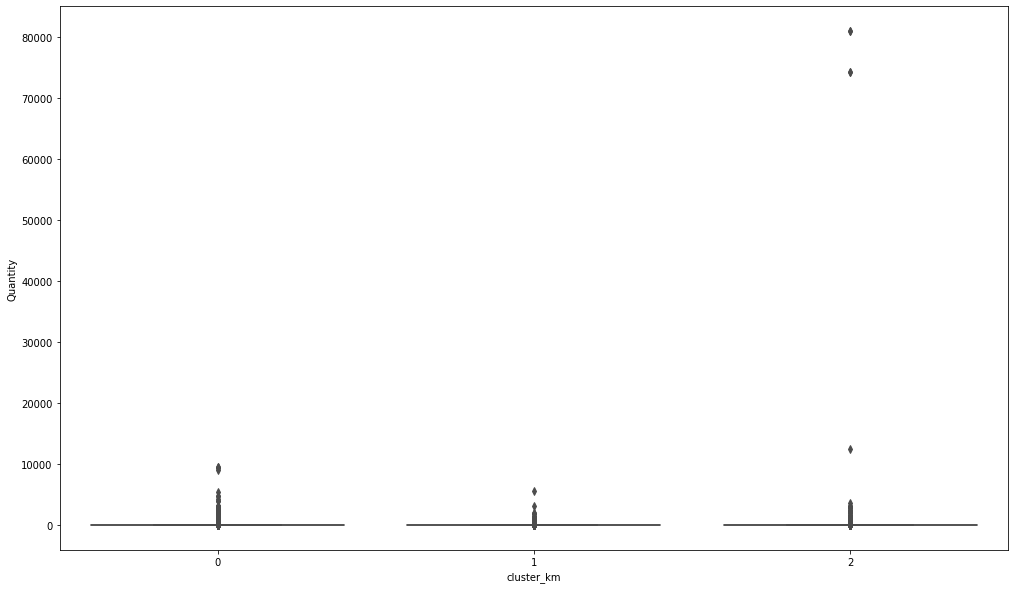

 UnitPrice distribution


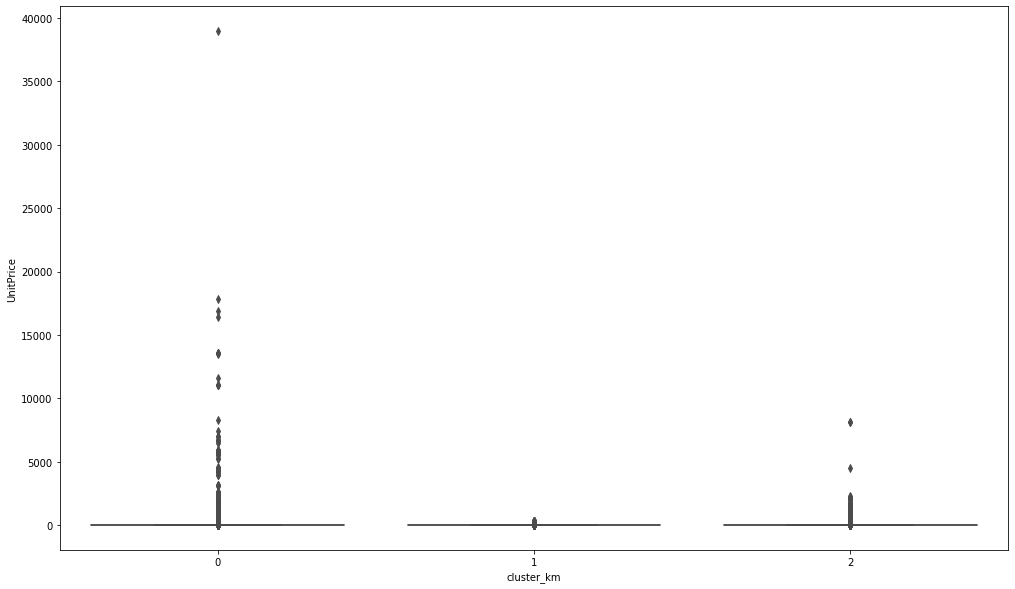

 month distribution


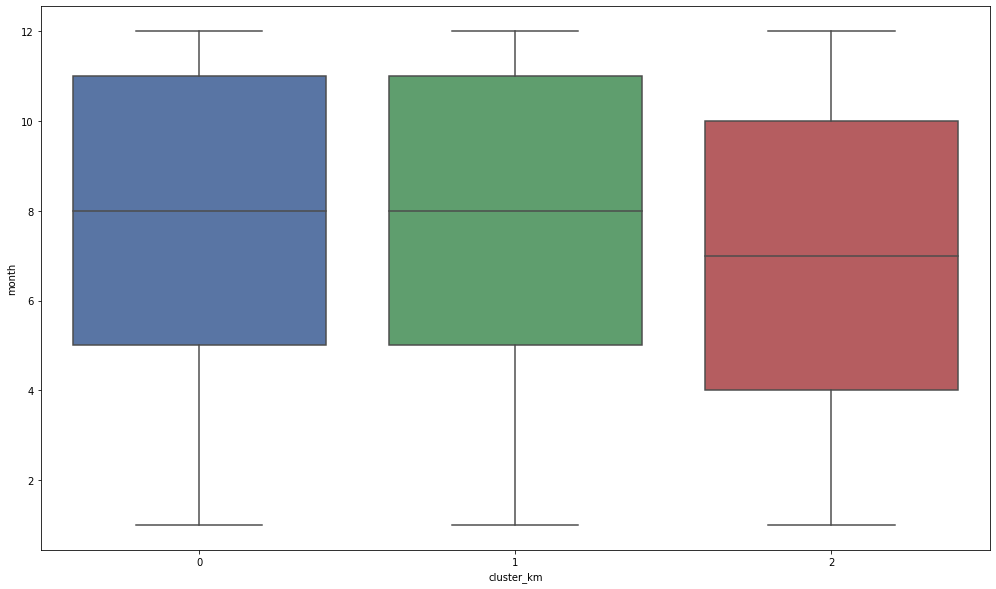

In [168]:
plt.style.use('seaborn-deep')
num_var = X[['Quantity', 'UnitPrice', 'month', 'cluster_km']]
num_var_1 = num_var.drop('cluster_km', axis = 1)

print('Numerical Featurs: ')
for column in num_var_1:
    print(' {:} distribution'.format(column))
    fig,ax=plt.subplots(figsize=(17,10))
    ax=sns.boxplot(x='cluster_km', y= column , data=num_var , showfliers = True)
    plt.show()

Numerical Featurs: 
 Quantity distribution


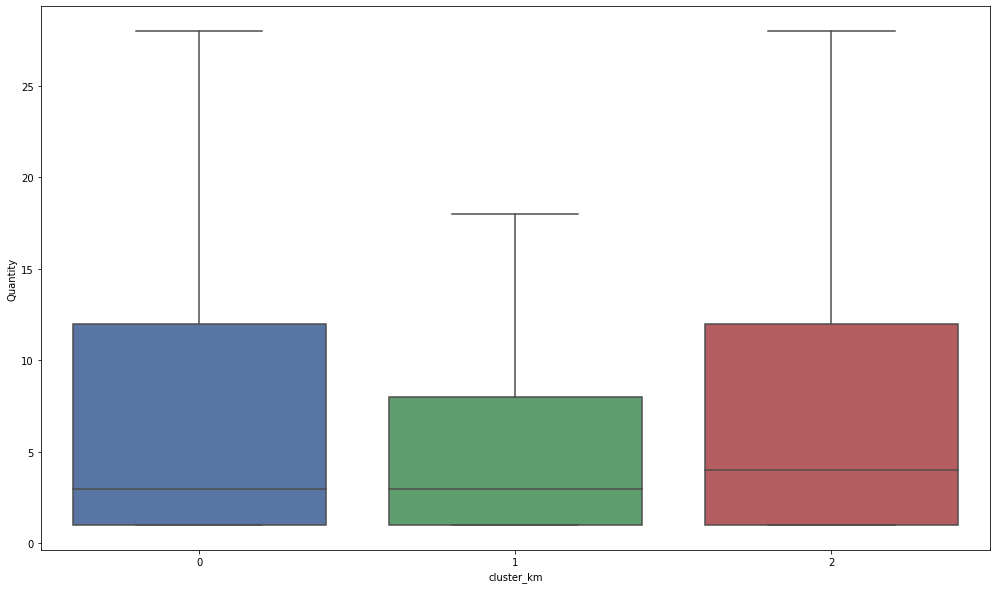

 UnitPrice distribution


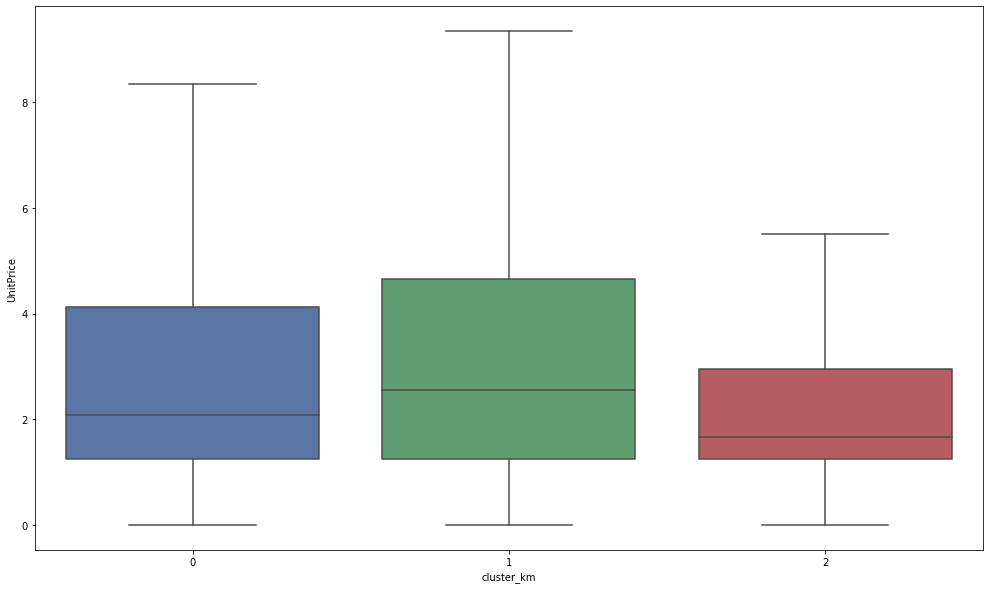

 month distribution


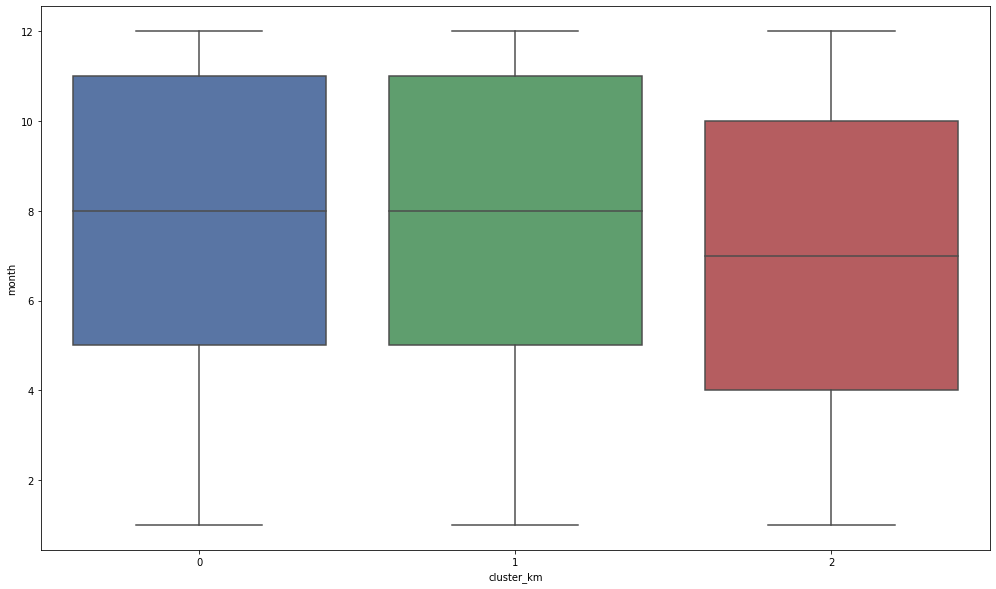

In [169]:
plt.style.use('seaborn-deep')
num_var = X[['Quantity', 'UnitPrice', 'month', 'cluster_km']]
num_var_1 = num_var.drop('cluster_km', axis = 1)

print('Numerical Featurs: ')
for column in num_var_1:
    print(' {:} distribution'.format(column))
    fig,ax=plt.subplots(figsize=(17,10))
    ax=sns.boxplot(x='cluster_km', y= column , data=num_var , showfliers = False)
    plt.show()

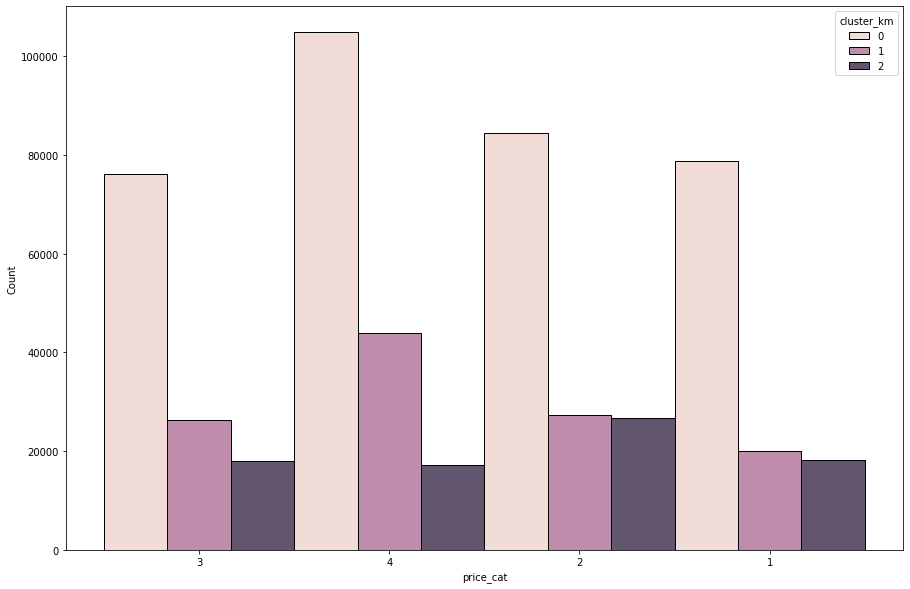

In [170]:
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots()
sns.histplot(
            data=X, x='price_cat', hue ='cluster_km' , multiple='dodge',
            bins=70, ax=ax
    )
plt.show()

In [171]:
num_var.groupby(['cluster_km'])['Quantity'].sum().reset_index().sort_values(by='Quantity',ascending=False)

,cluster_km,Quantity
0,0,3770215
2,2,1321746
1,1,1053551


- most goods ordered by quntity are of the 0 cluster.

In [173]:
num_var.groupby(['cluster_km'])['UnitPrice'].mean().reset_index().sort_values(by='UnitPrice',ascending=False)

,cluster_km,UnitPrice
2,2,5.639
0,0,4.824
1,1,3.665


- goods the 0 cluster, have higher avg price then of the other two. 

In [174]:
print(X.groupby('cluster_km').mean())

            Quantity  UnitPrice  month  clothes, bed linen and fabrics  \
cluster_km                                                               
0             10.952      4.824  7.554                           0.105   
1              8.961      3.665  7.502                           0.000   
2             16.503      5.639  7.196                           0.000   

            decorations, cometics and jewelery  food and groceries  furniture  \
cluster_km                                                                      
0                                        0.348               0.076      0.069   
1                                        0.000               0.000      0.000   
2                                        0.000               0.000      0.000   

            kitchen and cutlery  lighting  \
cluster_km                                  
0                         0.000     0.097   
1                         1.000     0.000   
2                         0.000     0.000  

**Conclusions:**

- Cluster 2 is defined by having items of only one category (utility tools, bags, office suplies and school supplies).

- Cluster 1 is also defined by having items of only one category (kitchen and cutlery).

- While 0 has items from multiple categories. food, furnitue, electronics and toys and so on...

- Cluster 0 is the most profitable both by ravenue and quantity of goods ordered.

## Project conclusions/recomindations

### Step 1. conclusions

- CustomerID missing data consists about 25% of all CustomerID values, too high a percent to be dropped, however a DataFrame without those values can be used for analysis of customer behavior.


- Description of items can theoretically be recovered from StockCode item identifier, StockCode can also be used instead of name for all intents and purposes. But 0.27% is really very insignificant so dropping it is also a very valid option.


- Autumn is the best season for sales. And the categories of decor and cutlery, lead in sells (probably because black Friday, Chinese singles day, Halloween and Chinese moon festival, All occur in Autumn).


- decor, cutlery and utility. Are the 3 categories leading in both number of orders and quantity ordred, more variability in those categories might prove beneficial.

- There is a preference of either affordable or luxury goods in the order ids, but cheap goods lead by order quantity.


- Heat map shows weak negative correlation between UnitPrice and Quantity, so stocking more luxury items might be a good idea.


- Previous charts show demand for cutlery, musical instruments and electronics, clothes, plants and decor in the luxury price category is grater then the other categories. So higher verity of goods of these categories that are luxury, is probably a good idea as this price category brings in more revenue.


- We reject H0 using significance level 0.05, There is a significant difference between the groups. Cheaper products probably have better sells online then more costly ones.


- Rejecting the null hypothesis for all categories and any and all seasons vs autumn, autumn is like no other season (it is special it seams...).


- Failed to reject the null hypothesis for most categories (all but fabrics, cutlery and devices) at seasons Spring and Winter, so ordering habits are for other categories seam very similar in those 2 seasons.


- Failed to reject the null hypothesis for most categories (all but fabrics and lighting) at seasons Summer and Winter, so ordering habits are for other categories seam very similar in those 2 seasons.


- Rejecting the null hypothesis for musical instruments, devices and electronics at seasons Spring and Summer, Failed to reject the null hypothesis for all other categories of these seasons so orders of other categories in those seasons are probably very similar.


### Step 2. recomindations

- decor, cutlery and utility. Are the 3 categories leading in both number of orders and quantity ordred, more variability in those categories might prove beneficial.

- Musical instruments and electronics of pricey(3) price category, show very low demand. So increasing product range in these categories are a probably a bad idea. 

- Any increases in product range should probably occur in Autumn, because Autumn is the best season for sales. 

### Step 3. Preparing a presentation

Presentation: <link to cloud storage: https://docs.google.com/presentation/d/1JaABqME7tCnZKaO3sjlqRFCYDGZhDtd6/edit?usp=sharing&ouid=117640590885420573053&rtpof=true&sd=true>

<div class="alert alert-block alert-info">
<b>Juniors answer.</b> <a class="tocSkip"></a>

Hello Lead! 
Thank you very much for the feedback. 
Hope now it's at least a wee bit better.
</div>